# Proceso ETL de los datos de pandemia de las Islas Canarias

En este documento se realizan los procesas de extracción, transformación y carga de los datos relacionados con la pandemia en las Islas Canarias.

Este proceso se realiza para 4 conjuntos de datos diferentes los cuales son:
* Datos de incidencia acumulada.
* Datos de pruebas PCR realizadas.
* Datos de ingresos diarios en los servicios de ugencua de los centros sanitarios.
* Ocupación diaria de los centros sanitarios

In [1]:
# Carga inicial de librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
# Métodos auxiliares que nos van a ayudar en los análisis

def comporbar_valores_perdidos(df):
    '''Comprueba si existen valores perdidos en el DataFrame
    
    Args:
    df (DataFrame): DataFrame con los datos para comprobar la existencia de datos perdidos
    '''
    # Buscamos los valores vacíos
    print("\nValores no definidos:")
    print(df.isna().sum())
    
    # Buscamos los valores nulos
    print("\nValores nulos:")
    print(df.isnull().sum())
    
    
# Fecha inicial desde la que se tienen los datos de casos de COVID
fecha_inicio = datetime(2021, 1, 1)
# Fecha final hasta la que se tienen los datos de casos de COVID
fecha_fin = datetime(2022, 3, 29)
# Rango de fechas de la que tenemos datos de casos de COVID
rango_fechas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')

def comprobar_fechas_isla(df):
    '''Comprueba si existe alguna fecha para lo que no se tenga datos de una isla
    
    Args:
    df (DataFrame): DataFrame con los datos de la serie temporal de los casos de COVID para una isla
    
    Returns:
    fechas_faltantes (list): Listado con las fechas para las que no se tiene datos
    '''
    fechas_faltantes = rango_fechas[~rango_fechas.isin(df['fecha'])]
    if len(fechas_faltantes) == 0:
        return []
    else:
        return fechas_faltantes.tolist()


def comprobar_fechas(df, islas):
    '''Realiza la comprobación para cada una de las islas del DataFrame si existe alguna fecha sin datos
    
    Args:
        df (DataFrame): DataFrame con los datos de la serie temporal de los casos de COVID de todas las islas
        islas(array): listado de islas a comprobar
    '''
    
    
    for isla in islas:
        print('Fechas faltantes para ' + isla + ': ' + str(comprobar_fechas_isla(df[df['isla'] == isla])))
        
        
def obtener_valores_extremos(df, columna):
    ''' Método que muestra un diagrama de caja con los valores extremos de la variable indicada para cada isla
    
    Args:
        df (DataFrame): DataFrame con los datos de la serie temporal de las islas
        columna(str): variable de la cual se quiere mostrar el diagrama de caja
    '''
    plt.figure(figsize=(10, 6))
    df.boxplot(column=columna, by='isla', figsize=(10, 6))
    
    plt.title('Diagrama de Caja agrupado por isla para la variable ' + columna)
    plt.xlabel('Isla')
    plt.ylabel(columna)
    plt.grid(True)
    
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')

    plt.tight_layout()
    plt.show()
    
    
def visualizar_evolutivo_islas(df, columna, titulo_variable):
    ''' Método que muestra un gráfico con el evolutivo de todas las islas para la variable indicada
    
    Args:
        df (DataFrame): DataFrame con los datos de la serie temporal de las islas
        columna(string): variable de la cual se quiere mostrar el evolutivo
        titulo_variable(string): título de la variable a mostrar en el gráfico
    '''
    
    plt.figure(figsize=(10, 8))
    
    colores = ['firebrick', 'tan', 'purple', 'olive', 'sienna', 'darkcyan', 'dodgerblue']
    
    for i,isla in enumerate(valores_islas):
        datos_isla = df[df['isla'] == isla]
        color = colores[i]
        plt.plot(datos_isla['fecha'], datos_isla[columna], label=isla, color=color)
        plt.title('Evolutivo ' + titulo_variable + ' para todas las islas')
        plt.xlabel('Fechas')
        plt.ylabel(columna)

    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')

    plt.legend()
    plt.show()
    
def visualizar_evolutivo_por_isla(df, columna, titulo_variable):
    '''Visualiza los datos de la serie temporal por isla
    
    Args:
    df (DataFrame): DataFrame con los datos de la serie temporal a mostrar para la variable indicada
    columna(string): variable de la que mostrar los datos
    titilo_variable(string): nombre a mostrar en el gráfico para la variable
    
    '''
    num_subplots = len(valores_islas)
    fig, axes = plt.subplots(num_subplots, 1, figsize=(8, 10), sharex=True)
    
    colores = ['firebrick', 'tan', 'purple', 'olive', 'sienna', 'darkcyan', 'dodgerblue']

    for i, isla in enumerate(valores_islas):
        datos_isla = df[df['isla'] == isla] 
        color = colores[i]
        axes[i].plot(datos_isla['fecha'], datos_isla[columna], color=color) 
        axes[i].set_title(isla) 
        axes[i].set_ylabel(columna)
        axes[i].set_facecolor('lightgrey')
        axes[i].grid(True, linestyle='--', linewidth=0.5, color='white')
    

    axes[-1].set_xlabel('Fecha')
    
    fig.suptitle("Evolutivo de " + titulo_variable + "  por isla", fontsize=14)

    plt.tight_layout()
    plt.show()
    
    
def obtener_valor_media_ant_sig(df, fecha, valor):
    '''Obtiene el valor medio entre la fecha anterior y la siguiente de la que se pasa por parámetro

    Args:
    df (DataFrame): DataFrame con los datos a obtener el valor medio
    fecha(DateTime): Fecha de la que se quiere obtener el valor
    valor(str): Nombre de la columna de la cual se quiere obtener el valor
    '''
    fecha_anterior = df.loc[df['fecha'] < fecha_faltante, 'fecha'].max()
    fecha_siguiente = df.loc[df['fecha'] > fecha_faltante, 'fecha'].min()
    
    valor_anterior = df.loc[df['fecha'] == fecha_anterior, valor].values[0]
    valor_siguiente = df.loc[df['fecha'] == fecha_siguiente, valor].values[0]
    
    return round(np.mean([valor_anterior, valor_siguiente]))

# Incidencia acumulada por isla

Realizamos los procesos ETL para los datos de la incidencia acumulada para cada una de las islas.

In [3]:
#Carga de ficheros de datos
datos_covid = pd.read_csv('../data/inicial/datos_covid/cv19_ia.csv', header=0)

In [4]:
#Obtenemos las dimensiones del dataframe
shape = datos_covid.shape

print("Número de atributos:", shape[1])
print("Número de filas :", shape[0])
print("Nombre de los atributos:", datos_covid.columns.values)

Número de atributos: 6
Número de filas : 3624
Nombre de los atributos: ['fecha_datos' 'isla' 'fecha' 'numero_casos' 'ia_7dias' 'ia_14dias']


Este dataset contiene 3624 registros que corresponden con los datos de casos de covid en las Islas Canarias y 6 variabless que los caracterizan.
La descripción de las variables obtenidas son:

* **fecha_datos:** Fecha en que se han extraido los datos de la base de datos de Sanidad.
* **isla:** Isla a la que pertenecen los datos.
* **fecha:** Fecha de los datos.
* **numero_casos:** Número total de casos covid declarados en la isla ese día.
* **ia_7dias:** Incidencia acumulada de casos covid calculada sobre los 7 días anteriores al día actual.
* **ia_14dias:** Incidencia acumulada de casos covid calculada sobre los 14 días anteriores al día actual.

Realizamos la búsqueda de valores vacíos en el conjunto de datos:

In [5]:
comporbar_valores_perdidos(datos_covid)


Valores no definidos:
fecha_datos     0
isla            0
fecha           0
numero_casos    0
ia_7dias        0
ia_14dias       0
dtype: int64

Valores nulos:
fecha_datos     0
isla            0
fecha           0
numero_casos    0
ia_7dias        0
ia_14dias       0
dtype: int64


Podemos observar que el conjunto de datos no posee valores perdidos. Mostramos la información de las variables para determinar que están en el tipo de datos correcto y visualizamos una muestra de los datos:

In [6]:
# Información de las variables
datos_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3624 entries, 0 to 3623
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   fecha_datos   3624 non-null   object
 1   isla          3624 non-null   object
 2   fecha         3624 non-null   object
 3   numero_casos  3624 non-null   int64 
 4   ia_7dias      3624 non-null   object
 5   ia_14dias     3624 non-null   object
dtypes: int64(1), object(5)
memory usage: 170.0+ KB


In [7]:
# Muestra del conjunto de datos.
datos_covid.head()

fecha_datos           isla       fecha  numero_casos           ia_7dias  \
0  29/03/2022      LANZAROTE  01/01/2021            14  48,13493184093652   
1  29/03/2022  FUERTEVENTURA  01/01/2021             1  25,89115691711489   
2  29/03/2022      EL HIERRO  01/01/2021             0  80,73921234412846   
3  29/03/2022      LA GOMERA  01/01/2021             0  46,12971676353907   
4  29/03/2022   GRAN CANARIA  01/01/2021            62  49,09289193368719   

            ia_14dias  
0    77,6576900367109  
1   49,27671800354124  
2  107,65228312550462  
3  156,84103699603284  
4   83,57480412520557

Vemos que las variables de fecha_datos, isla, fecha, ia_7dias, ia_14dias no están en el tipo de dato correcto por lo que realizamos la corrección. en cuanto a la fecha_datos tampoco se encuentra en el formato adecuado pero dado que es una variable que no vamos a utilizar y va a ser eliminada no realizamos la corrección del tipo de dato.

In [8]:
# Eliminamos la variable fecha_datos
datos_covid = datos_covid.drop(columns=['fecha_datos'])

# Convertimos las variables con tipos de datos incorrectos en los tipos de datos que le corresponden
datos_covid['fecha'] = pd.to_datetime(datos_covid['fecha'], dayfirst=True)
datos_covid['isla'] = datos_covid['isla'].astype(str)
datos_covid['ia_7dias'] = datos_covid['ia_7dias'].str.replace(',','.').astype(float)
datos_covid['ia_14dias'] = datos_covid['ia_14dias'].str.replace(',','.').astype(float)

In [9]:
# Información de las variables
datos_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3624 entries, 0 to 3623
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   isla          3624 non-null   object        
 1   fecha         3624 non-null   datetime64[ns]
 2   numero_casos  3624 non-null   int64         
 3   ia_7dias      3624 non-null   float64       
 4   ia_14dias     3624 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 141.7+ KB


In [10]:
# Muestra del conjunto de datos.
datos_covid.head()

isla      fecha  numero_casos   ia_7dias   ia_14dias
0      LANZAROTE 2021-01-01            14  48.134932   77.657690
1  FUERTEVENTURA 2021-01-01             1  25.891157   49.276718
2      EL HIERRO 2021-01-01             0  80.739212  107.652283
3      LA GOMERA 2021-01-01             0  46.129717  156.841037
4   GRAN CANARIA 2021-01-01            62  49.092892   83.574804

In [11]:
# Obtenemos el listado de islas del conjunto de datos
valores_islas = datos_covid['isla'].unique()
print("Valores de islas:", valores_islas)

Valores de islas: ['LANZAROTE' 'FUERTEVENTURA' 'EL HIERRO' 'LA GOMERA' 'GRAN CANARIA'
 'LA PALMA' 'TENERIFE' 'CANARIAS']


Podemos observar que aparte de los datos por isla, también existen los datos para toda la comunidad autónoma de Canarias por lo que eliminamos los datos de esta para poder hacer nuestro estudio en función de cada una de las islas.

In [12]:
# Eliminamos los datos de la CCAA de Canarias
datos_covid = datos_covid[datos_covid['isla'] != 'CANARIAS']
# Lo eliminamos también del listado de islas
valores_islas = valores_islas[:-1]

In [13]:
#Comprobamos si existe alguna fecha de la serie temporal e isla para la que no se tenga datos
comprobar_fechas(datos_covid, valores_islas)

Fechas faltantes para LANZAROTE: []
Fechas faltantes para FUERTEVENTURA: []
Fechas faltantes para EL HIERRO: []
Fechas faltantes para LA GOMERA: []
Fechas faltantes para GRAN CANARIA: []
Fechas faltantes para LA PALMA: []
Fechas faltantes para TENERIFE: []


Podemos observar que no hay fechas para las que no existan datos del número de casos en el periodo comprendido entre 01/01/2021 y 29/03/2022

In [14]:
# Constantes con los nombres de las columnas a visualizar el diagrama de caja y el evolutivo
n_casos = 'numero_casos'
ia_7d = 'ia_7dias'
ia_14d = 'ia_14dias'

tit_n_casos = 'número de casos de COVID'
tit_ia_7d = 'incidencia acumulada 7 días'
tit_ia_14d = 'incidencia acumulada 14 días'

Visualizamos el diagrama de caja para evaluar los valores extremos.

<Figure size 1000x600 with 0 Axes>

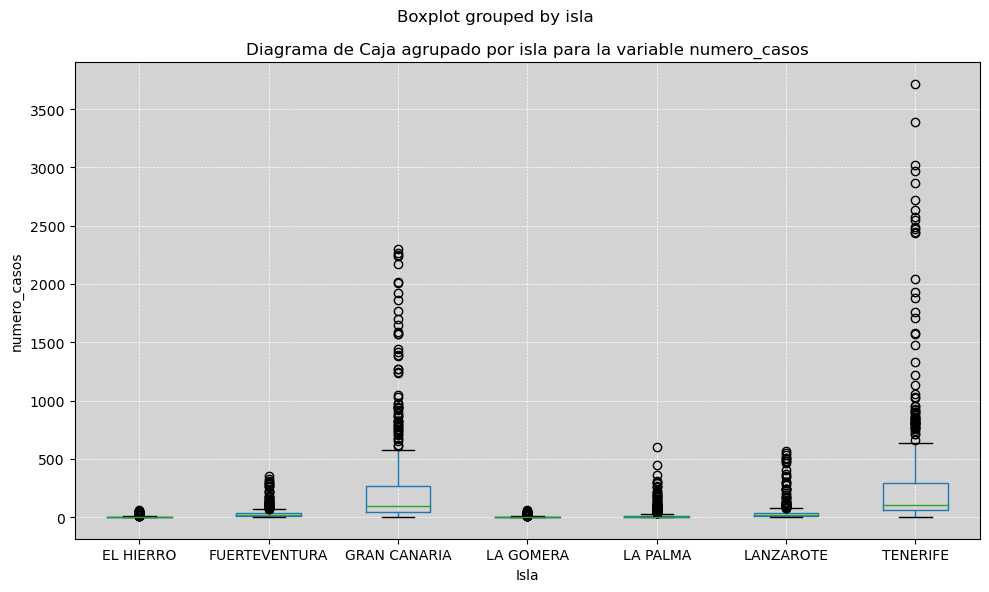

In [15]:
obtener_valores_extremos(datos_covid, n_casos)

Visualizamos la evolución de los datos de todas las islas juntas.

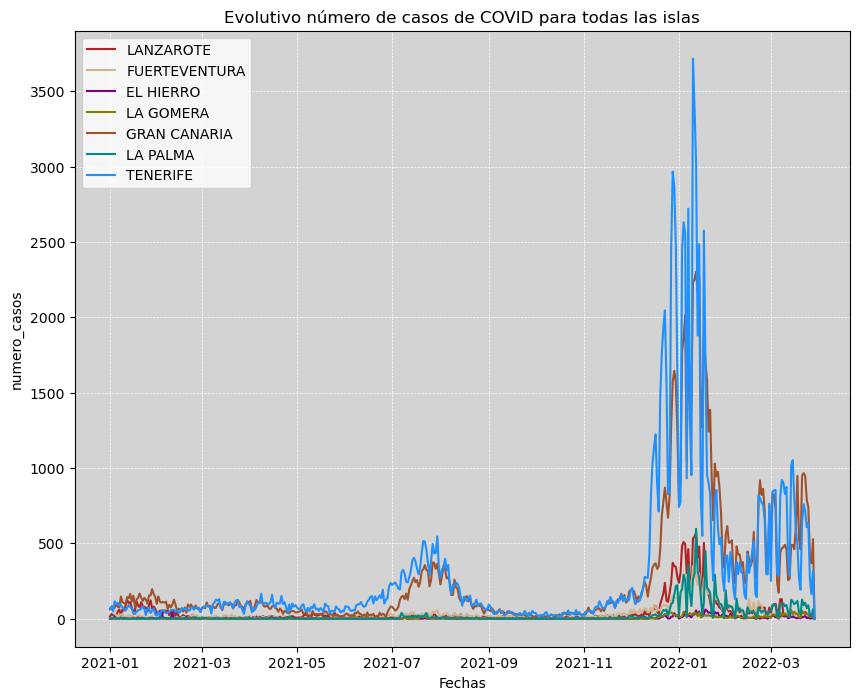

In [16]:
visualizar_evolutivo_islas(datos_covid, n_casos, tit_n_casos)

Visualizamos la evolución de los datos para cada isla individualmente.

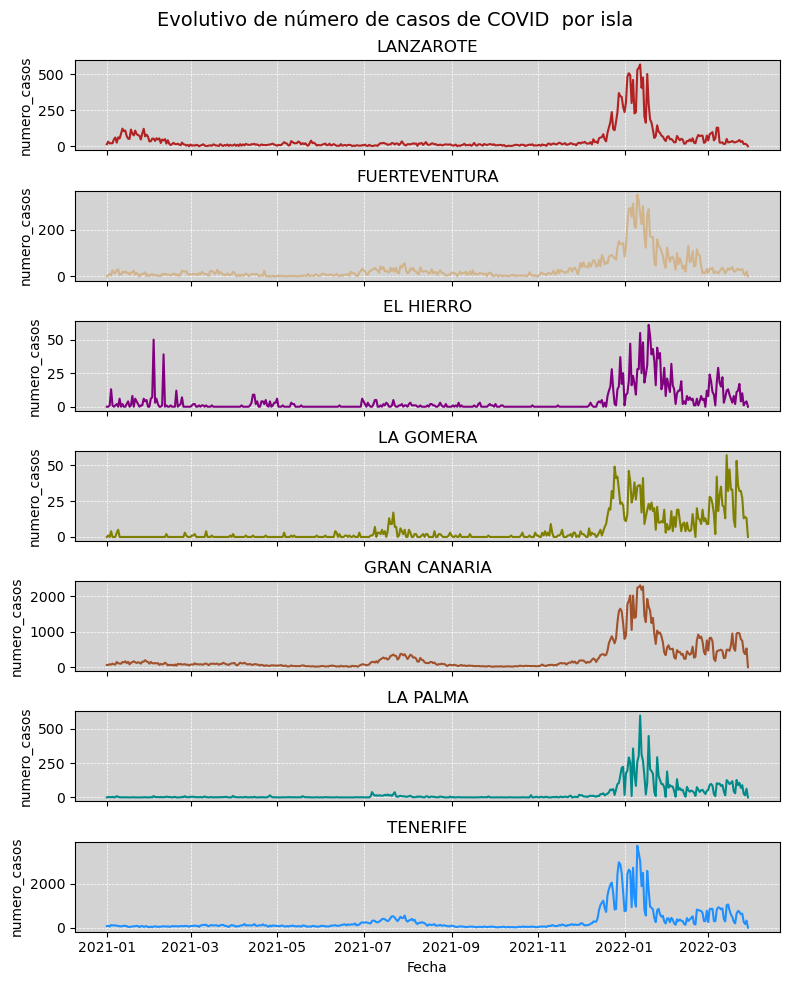

In [17]:
visualizar_evolutivo_por_isla(datos_covid, n_casos, tit_n_casos)

Visualizamos el diagrama de caja para evaluar los valores extremos.

<Figure size 1000x600 with 0 Axes>

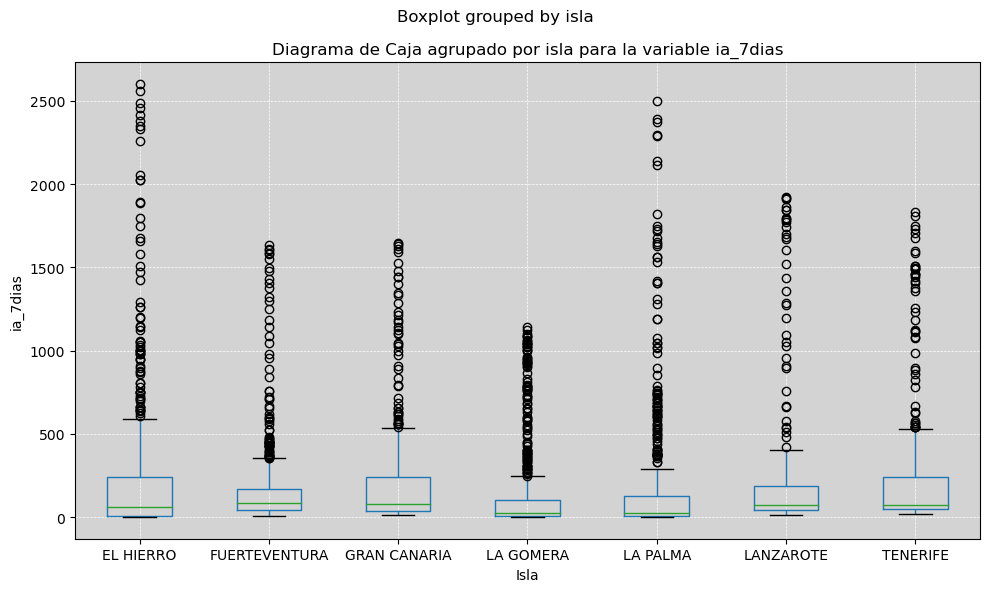

In [18]:
obtener_valores_extremos(datos_covid, ia_7d)

Visualizamos la evolución de los datos de todas las islas juntas.

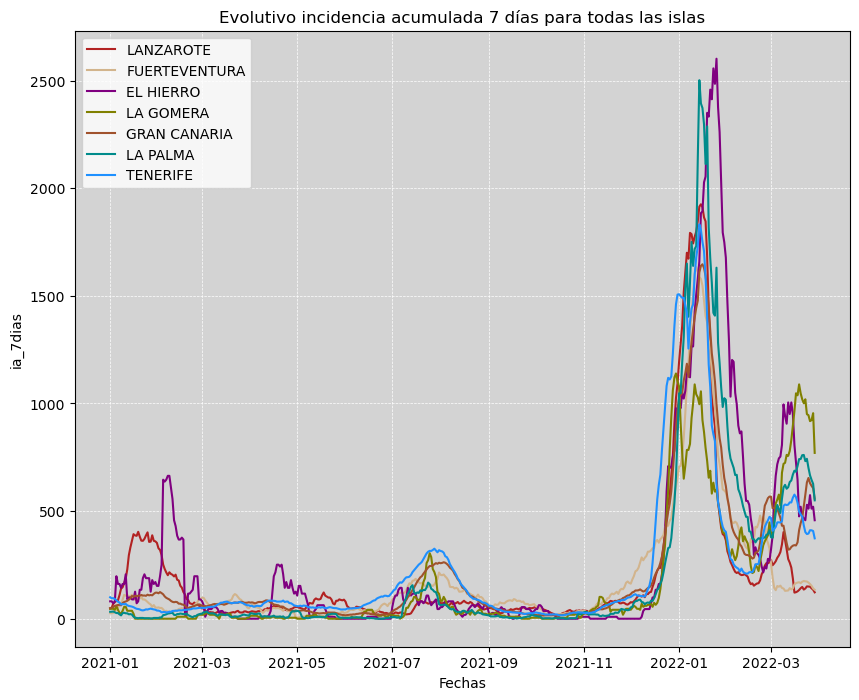

In [19]:
visualizar_evolutivo_islas(datos_covid, ia_7d, tit_ia_7d)

Visualizamos la evolución de los datos para cada isla individualmente.

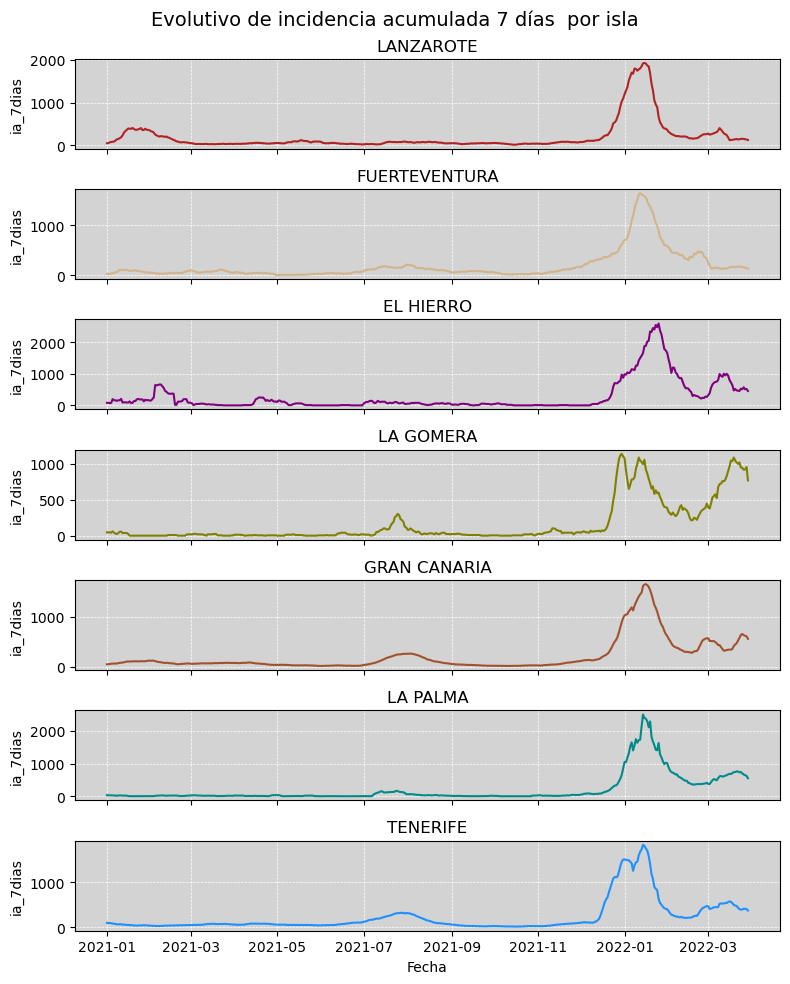

In [20]:
visualizar_evolutivo_por_isla(datos_covid, ia_7d, tit_ia_7d)

Visualizamos el diagrama de caja para evaluar los valores extremos.

<Figure size 1000x600 with 0 Axes>

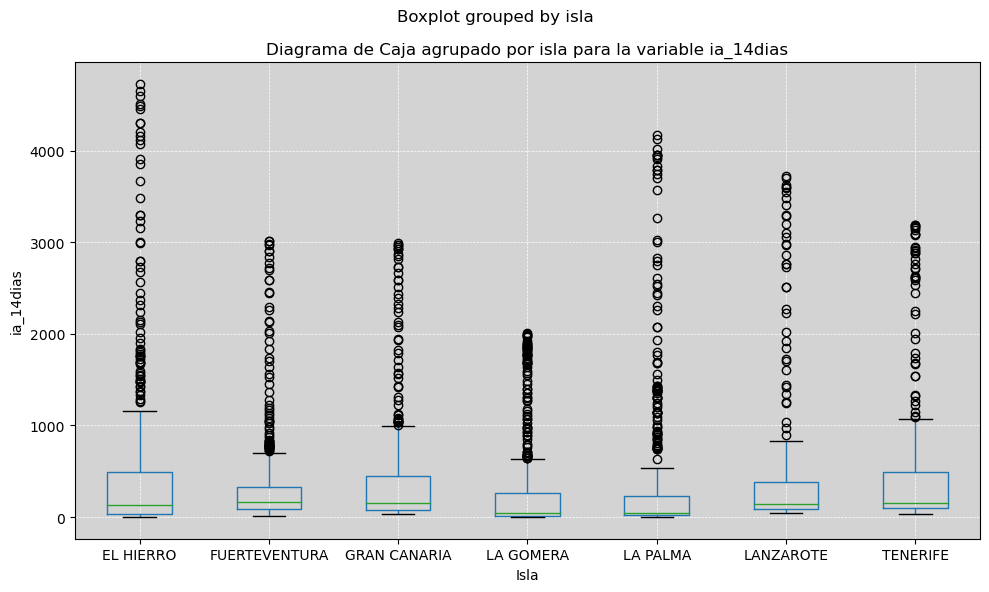

In [21]:
obtener_valores_extremos(datos_covid, ia_14d)

Visualizamos la evolución de los datos de todas las islas juntas.

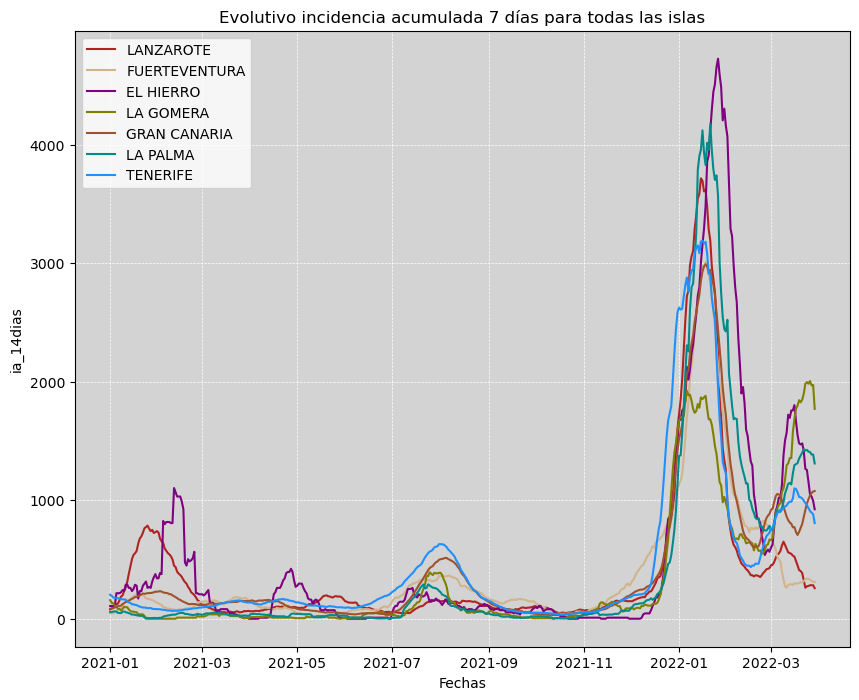

In [22]:
visualizar_evolutivo_islas(datos_covid, ia_14d, tit_ia_7d)

Visualizamos la evolución de los datos para cada isla individualmente.

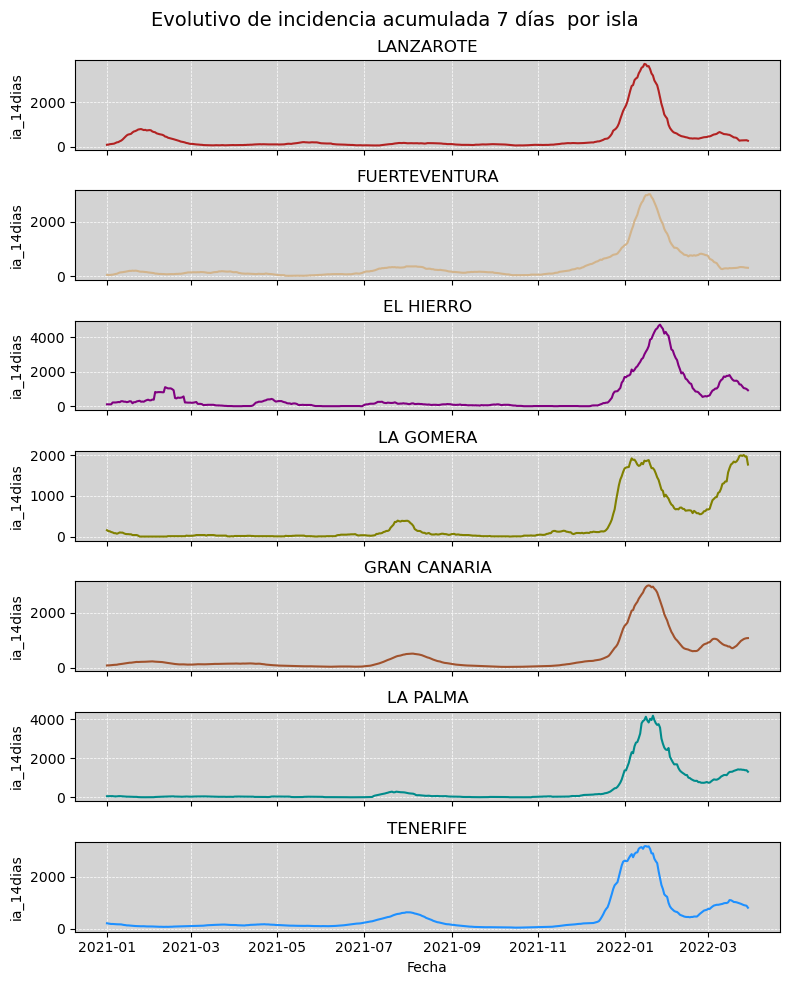

In [23]:
visualizar_evolutivo_por_isla(datos_covid, ia_14d, tit_ia_7d)

# Resultados de test PCR realizados por isla

Realizamos el proceso ETL para los test PCR realizado en cada una de las islas.

In [24]:
#Carga de ficheros de datos
datos_pcrs = pd.read_csv('../data/inicial/datos_covid/cv19_pcr_porcentaje.csv', header=0)

In [25]:
#Obtenemos las dimensiones del dataframe
shape = datos_pcrs.shape

print("Número de atributos:", shape[1])
print("Número de filas :", shape[0])
print("Nombre de los atributos:", datos_pcrs.columns.values)

Número de atributos: 7
Número de filas : 3616
Nombre de los atributos: ['fecha_datos' 'isla' 'fecha' 'pcr_total' 'pcr_positivos'
 'pcr_porcentaje_positivos' 'pcr_porcentaje_positivos_7dias']


Este dataset contiene 3616 registros que corresponden con los datos de resultados de test PCR realizados en las Islas Canarias por isla y 7 variables que los caracterizan.

La descripción de las variables obtenidas son:

* **fecha_datos:** Fecha en que se han extraido los datos de la base de datos de Sanidad.
* **isla:** Isla a la que pertenecen los datos.
* **fecha:** Fecha de los datos.
* **pcr_total:** Número total de test pcr realizados en esa isla ese día.
* **pcr_positivos:** Número total de test pcr realizados en esa isla ese día que dieron positivo.
* **pcr_porcentaje_positivos:** Porcentaje de test pcr realizados en esa isla ese día que dieron positivo.
* **pcr_porcentaje_positivos_7dias:** Porcentaje de test pcr realizados en esa isla ese día que dieron positivo acumulado en los 7 días anteriores a la fecha actual.

Realizamos la búsqueda de valores vacíos en el conjunto de datos:

In [26]:
comporbar_valores_perdidos(datos_pcrs)


Valores no definidos:
fecha_datos                       0
isla                              0
fecha                             0
pcr_total                         0
pcr_positivos                     0
pcr_porcentaje_positivos          0
pcr_porcentaje_positivos_7dias    0
dtype: int64

Valores nulos:
fecha_datos                       0
isla                              0
fecha                             0
pcr_total                         0
pcr_positivos                     0
pcr_porcentaje_positivos          0
pcr_porcentaje_positivos_7dias    0
dtype: int64


Podemos observar que el conjunto de datos no posee valores perdidos. Mostramos la información de las variables para determinar que están en el tipo de datos correcto y visualizamos una muestra de los datos:

In [27]:
# Información de las variables
datos_pcrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3616 entries, 0 to 3615
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   fecha_datos                     3616 non-null   object
 1   isla                            3616 non-null   object
 2   fecha                           3616 non-null   object
 3   pcr_total                       3616 non-null   int64 
 4   pcr_positivos                   3616 non-null   int64 
 5   pcr_porcentaje_positivos        3616 non-null   object
 6   pcr_porcentaje_positivos_7dias  3616 non-null   object
dtypes: int64(2), object(5)
memory usage: 197.9+ KB


In [28]:
# Muestra del conjunto de datos.
datos_pcrs.head()

fecha_datos       isla       fecha  pcr_total  pcr_positivos  \
0  29/03/2022  EL HIERRO  01/01/2021          1              0   
1  29/03/2022  EL HIERRO  02/01/2021         39              0   
2  29/03/2022  EL HIERRO  03/01/2021          8              1   
3  29/03/2022  EL HIERRO  04/01/2021         39             16   
4  29/03/2022  EL HIERRO  05/01/2021         20              5   

  pcr_porcentaje_positivos pcr_porcentaje_positivos_7dias  
0                        0              4,529616724738676  
1                        0              4,529616724738676  
2                     12,5              3,833865814696486  
3        41,02564102564103              4,088050314465409  
4                       25                              8

Vemos que las variables de fecha_datos, isla, fecha, pcr_porcentaje_positivos y pcr_porcentaje_positivos_7dias no están en el tipo de dato correcto por lo que realizamos la corrección. En cuanto a la fecha_datos tampoco se encuentra en el formato adecuado pero dado que es una variable que no vamos a utilizar y va a ser eliminada por lo que no realizamos la corrección del tipo de dato.

In [29]:
# Eliminamos la variable fecha_datos
datos_pcrs = datos_pcrs.drop(columns=['fecha_datos'])

# Convertimos las variables con tipos de datos incorrectos en los tipos de datos que le corresponden
datos_pcrs['fecha'] = pd.to_datetime(datos_pcrs['fecha'], dayfirst=True)
datos_pcrs['isla'] = datos_pcrs['isla'].astype(str)
datos_pcrs['pcr_porcentaje_positivos'] = datos_pcrs['pcr_porcentaje_positivos'].str.replace(',','.').astype(float)
datos_pcrs['pcr_porcentaje_positivos_7dias'] = datos_pcrs['pcr_porcentaje_positivos_7dias'].str.replace(',','.').astype(float)

In [30]:
# Información de las variables
datos_pcrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3616 entries, 0 to 3615
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   isla                            3616 non-null   object        
 1   fecha                           3616 non-null   datetime64[ns]
 2   pcr_total                       3616 non-null   int64         
 3   pcr_positivos                   3616 non-null   int64         
 4   pcr_porcentaje_positivos        3616 non-null   float64       
 5   pcr_porcentaje_positivos_7dias  3616 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 169.6+ KB


In [31]:
# Muestra del conjunto de datos.
datos_pcrs.head()

isla      fecha  pcr_total  pcr_positivos  pcr_porcentaje_positivos  \
0  EL HIERRO 2021-01-01          1              0                  0.000000   
1  EL HIERRO 2021-01-02         39              0                  0.000000   
2  EL HIERRO 2021-01-03          8              1                 12.500000   
3  EL HIERRO 2021-01-04         39             16                 41.025641   
4  EL HIERRO 2021-01-05         20              5                 25.000000   

   pcr_porcentaje_positivos_7dias  
0                        4.529617  
1                        4.529617  
2                        3.833866  
3                        4.088050  
4                        8.000000

In [32]:
# Obtenemos el listado de islas del conjunto de datos
valores_islas_pcr = datos_pcrs['isla'].unique()
print("Valores de islas:", valores_islas_pcr)

Valores de islas: ['EL HIERRO' 'LA PALMA' 'LA GOMERA' 'TENERIFE' 'GRAN CANARIA'
 'FUERTEVENTURA' 'LANZAROTE' 'CANARIAS']


Podemos observar que nuevamente nos encontramos con que tenemos datos globales de la comunidad autónoma de Canarias por lo que los eliminameros para la realización de nuestro estudio.

In [33]:
# Eliminamos los datos de la CCAA de Canarias
datos_pcrs = datos_pcrs[datos_pcrs['isla'] != 'CANARIAS']
# Lo eliminamos también del listado de islas
valores_islas_pcr = valores_islas_pcr[:-1]

In [34]:
comprobar_fechas(datos_pcrs, valores_islas)

Fechas faltantes para LANZAROTE: [Timestamp('2022-03-29 00:00:00')]
Fechas faltantes para FUERTEVENTURA: [Timestamp('2022-03-29 00:00:00')]
Fechas faltantes para EL HIERRO: [Timestamp('2022-03-29 00:00:00')]
Fechas faltantes para LA GOMERA: [Timestamp('2022-03-29 00:00:00')]
Fechas faltantes para GRAN CANARIA: [Timestamp('2022-03-29 00:00:00')]
Fechas faltantes para LA PALMA: [Timestamp('2022-03-29 00:00:00')]
Fechas faltantes para TENERIFE: [Timestamp('2022-03-29 00:00:00')]


Podemos ver que para la serie temporal de los datos de resultados de PCRs no tenemos los datos de la fecha 29/03/2022 correspondiente con la última fecha de datos de casos de COVID por lo que acotaremos los datos quedandonos con el rango de fechas del 01/01/2021 hasta el 28/03/2022.

Una vez tenemos los datos en formato correcto vamos a fusionar los datos de los casos de COVID con el de resultados PCRs de forma que tengamos todos los datos en un solo DataFrame. Para realizar la fusión utilizaremos como claves las variables fecha e isla. Antes de realizar la fusión debemos modificar el tipo de dato de las fechas ya que no podemos realizar una fusión con este tipo de dato, por lo que convertimos la variable DateTime a String para poder realizar la fusión. Una vez realicemos la fusión devolveremos el tipo de dato correcto a la variable.

In [35]:
# Constantes con las variables de las que visualizar el diagrama de caja y el evolutivo
pcr_t = 'pcr_total'
pcr_pos = 'pcr_positivos'
pcr_por_pos = 'pcr_porcentaje_positivos'
pcr_por_pos_7d = 'pcr_porcentaje_positivos_7dias'


tit_pcr_t = 'PCR totales'
tit_pcr_pos = 'PCR positivas'
tit_pcr_por_pos = 'porcentaje PCR positivos'
tit_pcr_por_pos_7d = 'porcentaje PCR positivos en los últimos 7 días'

Visualizamos el diagrama de caja para evaluar los valores extremos.

<Figure size 1000x600 with 0 Axes>

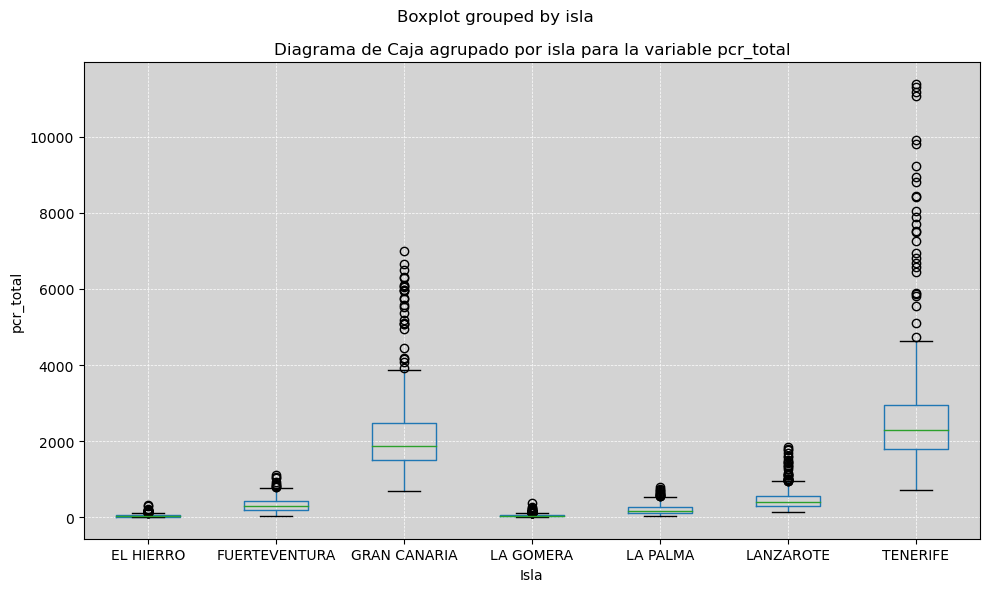

In [36]:
obtener_valores_extremos(datos_pcrs, pcr_t)

Visualizamos la evolución de los datos de todas las islas juntas.

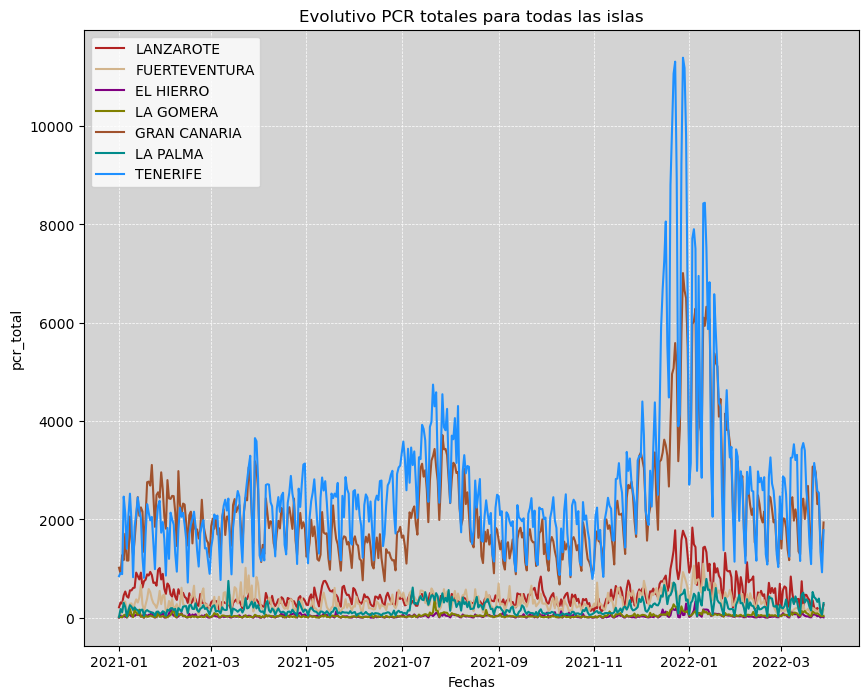

In [37]:
visualizar_evolutivo_islas(datos_pcrs, pcr_t, tit_pcr_t)

Visualizamos la evolución de los datos para cada isla individualmente.

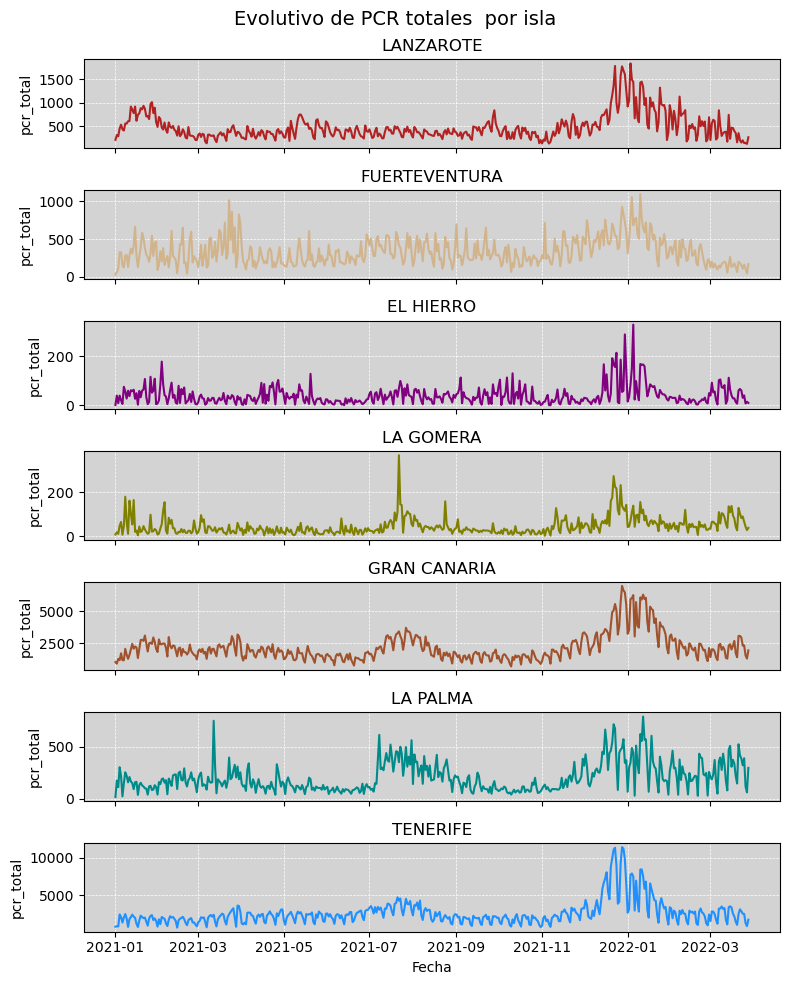

In [38]:
visualizar_evolutivo_por_isla(datos_pcrs, pcr_t,tit_pcr_t)

Visualizamos el diagrama de caja para evaluar los valores extremos.

<Figure size 1000x600 with 0 Axes>

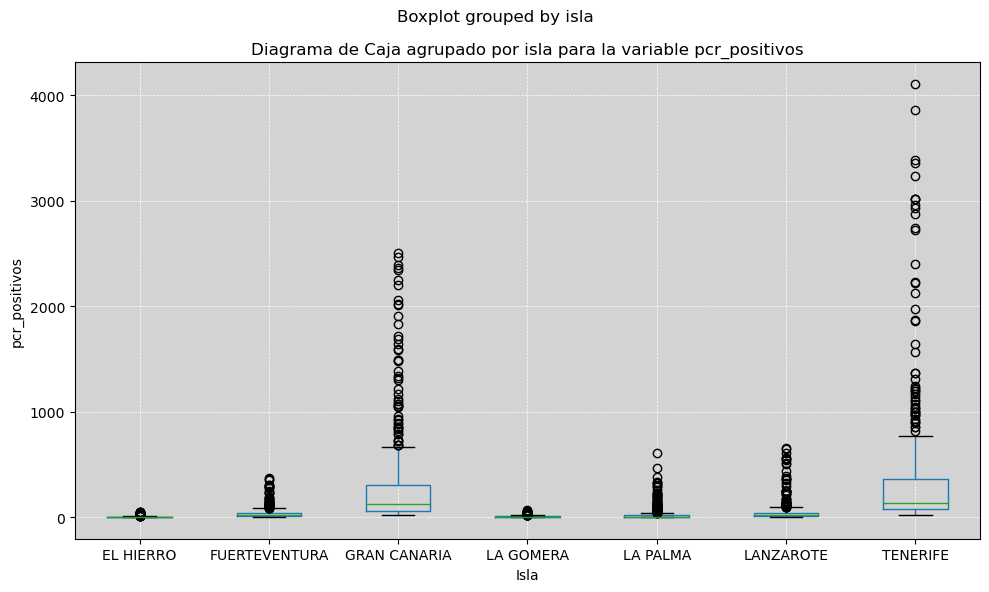

In [39]:
obtener_valores_extremos(datos_pcrs, pcr_pos)

Visualizamos la evolución de los datos de todas las islas juntas.

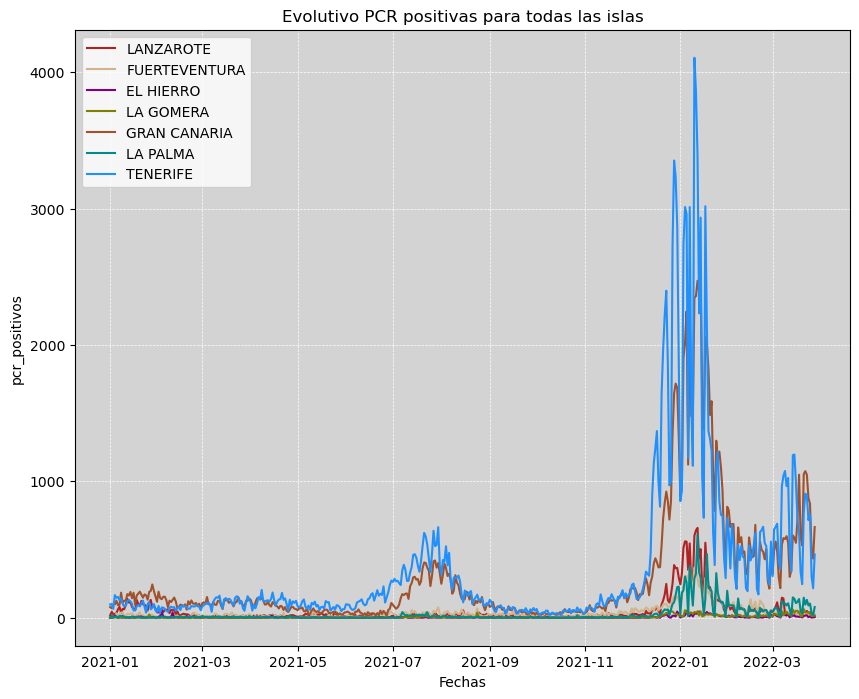

In [40]:
visualizar_evolutivo_islas(datos_pcrs, pcr_pos, tit_pcr_pos)

Visualizamos la evolución de los datos para cada isla individualmente.

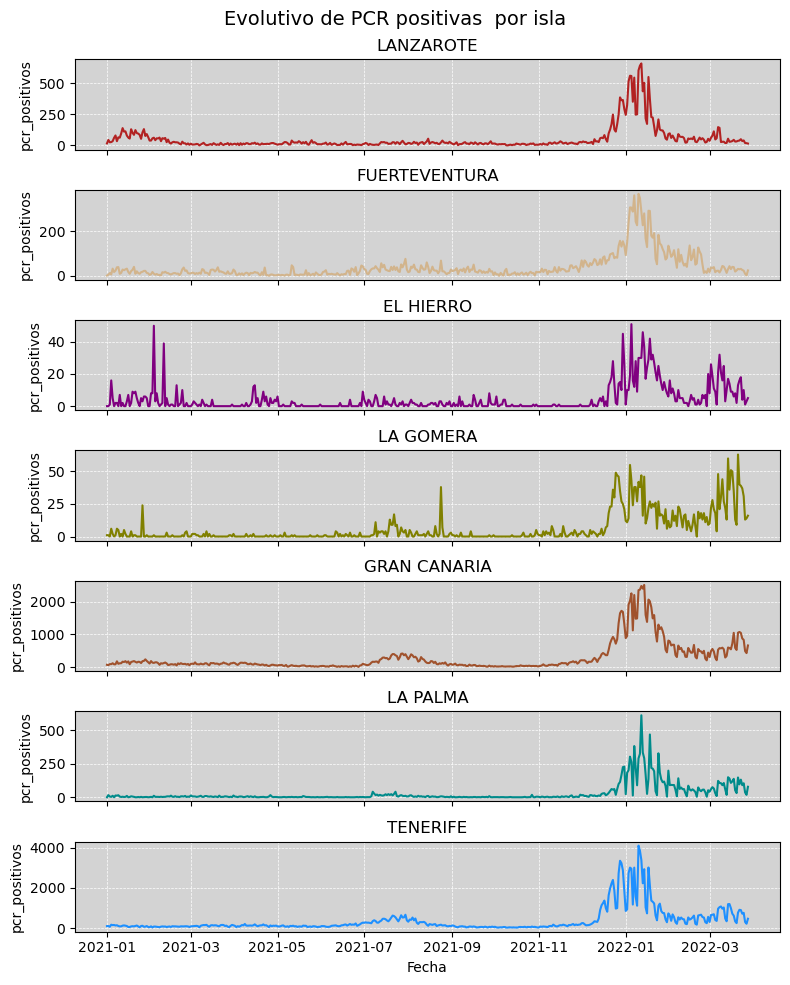

In [41]:
visualizar_evolutivo_por_isla(datos_pcrs, pcr_pos, tit_pcr_pos)

Visualizamos el diagrama de caja para evaluar los valores extremos.

<Figure size 1000x600 with 0 Axes>

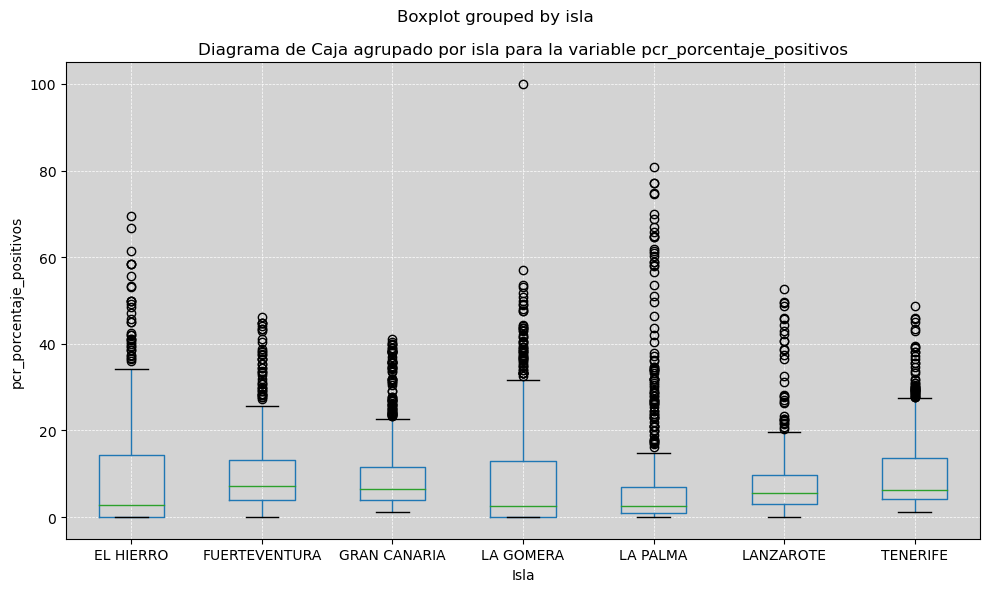

In [42]:
obtener_valores_extremos(datos_pcrs, pcr_por_pos)

Visualizamos la evolución de los datos de todas las islas juntas.

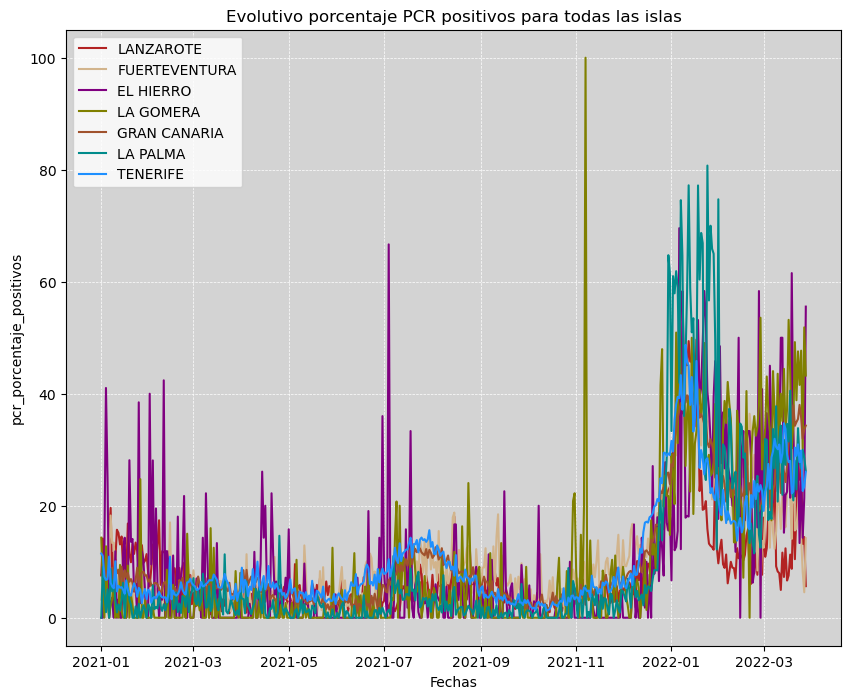

In [43]:
visualizar_evolutivo_islas(datos_pcrs, pcr_por_pos, tit_pcr_por_pos)

Visualizamos la evolución de los datos para cada isla individualmente.

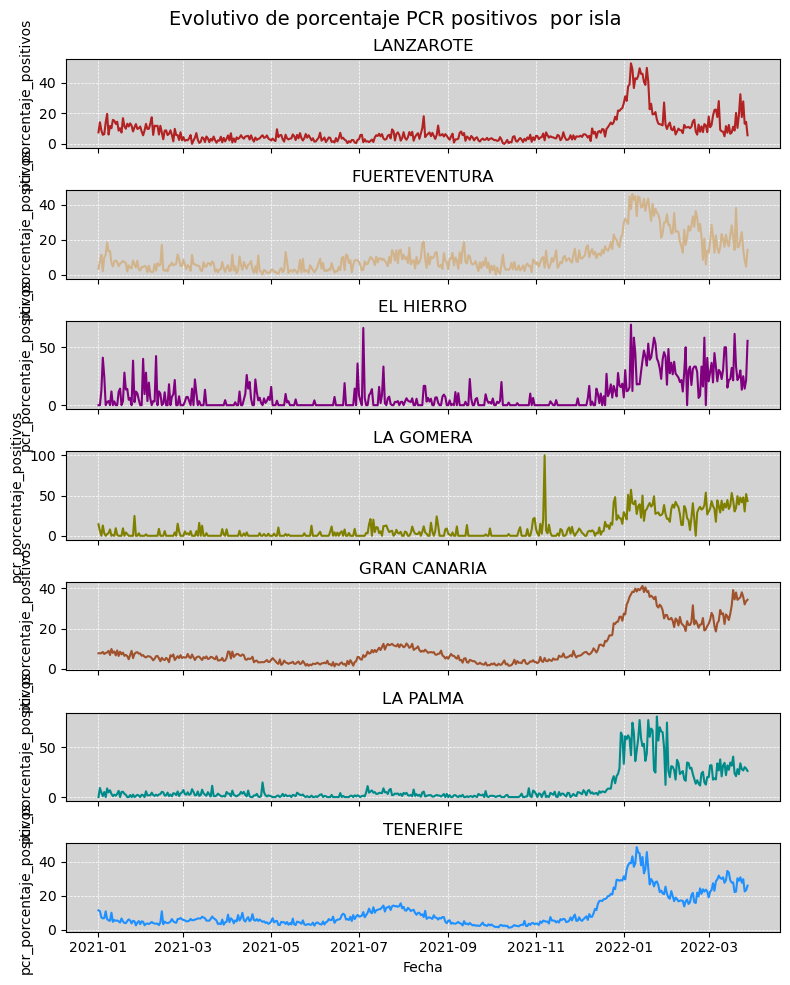

In [44]:
visualizar_evolutivo_por_isla(datos_pcrs, pcr_por_pos, tit_pcr_por_pos)

Visualizamos el diagrama de caja para evaluar los valores extremos.

<Figure size 1000x600 with 0 Axes>

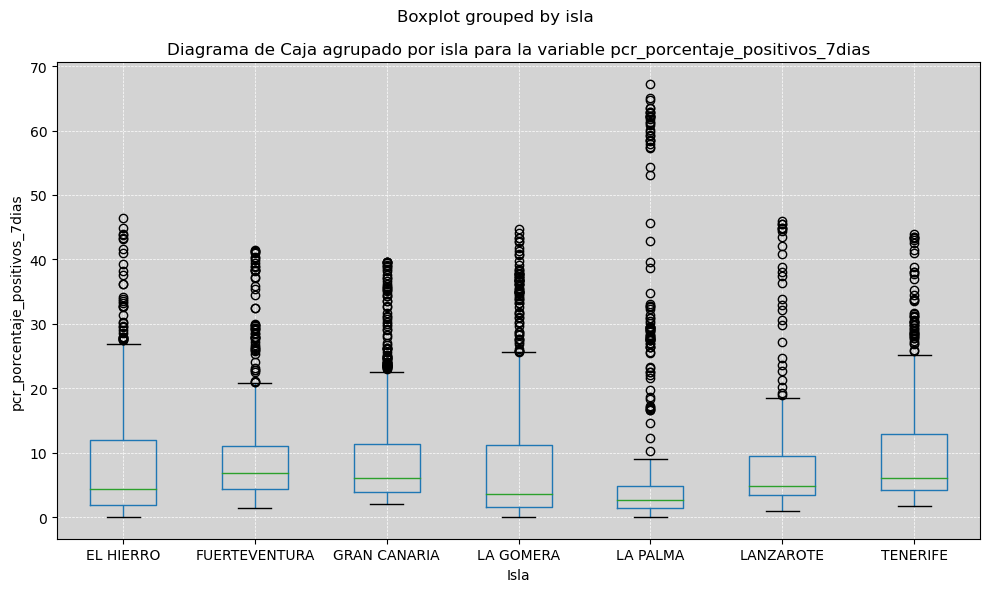

In [45]:
obtener_valores_extremos(datos_pcrs, pcr_por_pos_7d)

Visualizamos la evolución de los datos de todas las islas juntas.

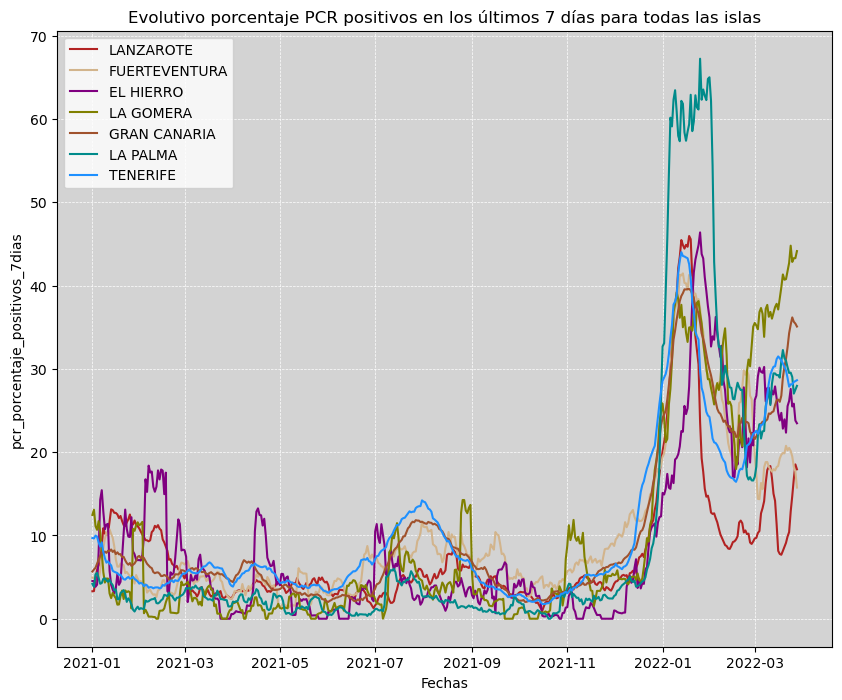

In [46]:
visualizar_evolutivo_islas(datos_pcrs, pcr_por_pos_7d, tit_pcr_por_pos_7d)

Visualizamos la evolución de los datos para cada isla individualmente.

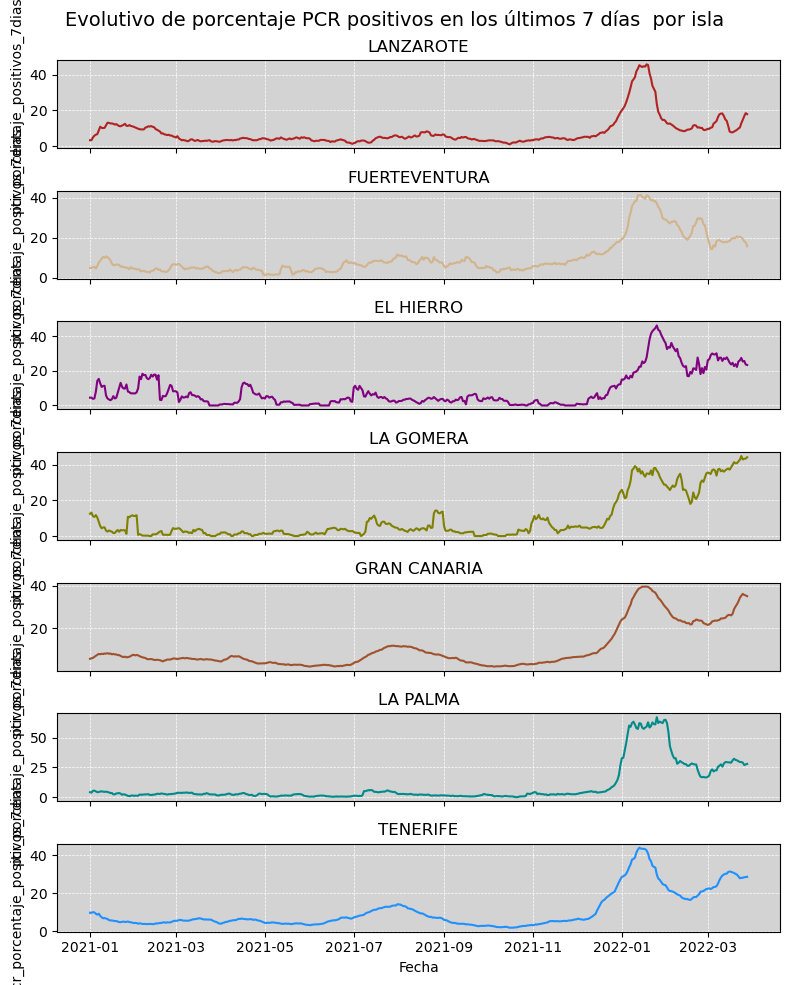

In [47]:
visualizar_evolutivo_por_isla(datos_pcrs, pcr_por_pos_7d, tit_pcr_por_pos_7d)

In [48]:
# Para poder hacer la fusión debemos de pasar los datos a tipo string ya que es una de las claves de la fusión
datos_covid['fecha'] = datos_covid['fecha'].astype(str)
datos_pcrs['fecha'] = datos_pcrs['fecha'].astype(str)

In [49]:
# Fusionamos los datos de ambos DataFramne
df_covid_final = pd.merge(datos_covid, datos_pcrs, on=['fecha', 'isla'], how='inner')

In [50]:
# Devolvemos el tipo DateTime a la variable fecha
df_covid_final['fecha'] = pd.to_datetime(df_covid_final['fecha'])

In [51]:
# Mostramos el resultado de la fusión
df_covid_final

isla      fecha  numero_casos    ia_7dias    ia_14dias  \
0         LANZAROTE 2021-01-01            14   48.134932    77.657690   
1     FUERTEVENTURA 2021-01-01             1   25.891157    49.276718   
2         EL HIERRO 2021-01-01             0   80.739212   107.652283   
3         LA GOMERA 2021-01-01             0   46.129717   156.841037   
4      GRAN CANARIA 2021-01-01            62   49.092892    83.574804   
...             ...        ...           ...         ...          ...   
3159      LANZAROTE 2022-03-28            13  134.777809   282.391600   
3160      LA GOMERA 2022-03-28            13  954.885137  1974.351877   
3161       LA PALMA 2022-03-28            63  626.662513  1386.326056   
3162      EL HIERRO 2022-03-28             4  520.319368   995.783619   
3163  FUERTEVENTURA 2022-03-28            22  140.313367   312.364280   

      pcr_total  pcr_positivos  pcr_porcentaje_positivos  \
0           212             16                  7.547170   
1            31              1                  3.225806   
2             1              0                  0.000000   
3             7              1                 14.285714   
4          1017             78                  7.669617   
...         ...            ...                       ...   
3159        266             15                  5.639098   
3160         37             16                 43.243243   
3161        298             78                 26.174497   
3162          9              5                 55.555556   
3163        169             24                 14.201183   

      pcr_porcentaje_positivos_7dias  
0                           3.298153  
1                           4.934823  
2                           4.529617  
3                          12.459016  
4                           5.668176  
...                              ...  
3159                       17.935192  
3160                       44.134078  
3161                       27.955056  
3162                       23.465704  
3163                       15.745568  

[3164 rows x 9 columns]

# Limpieza de datos de ingresos diarios por el servicio de Urgencias de los centros sanitarios en Canarias

Realizamos el proceso de ETL para los datos de ingresos diarios en el servicio de urgencias de los centros sanitarios.

In [52]:
#Carga de ficheros de datos
datos_centros = pd.read_csv('../data/inicial/datos_capacidad_asistencial/csv_capacidad_asistencial_centros.csv', header=0)
datos_urgencias = pd.read_csv('../data/inicial/datos_capacidad_asistencial/csv_ingresos_urgencias_diarios.csv', header=0)

In [53]:
datos_urgencias.head()

fecha_datos  codigo       fecha     serie  valor
0  30/06/2023  350367  25/09/2020  Urg_ingr     23
1  30/06/2023  350228  10/12/2021  Urg_ingr     16
2  30/06/2023  350290  20/03/2023    Urg_cv      0
3  30/06/2023  380146  16/03/2022  Urg_ingr     30
4  30/06/2023  380316  09/01/2023  Urg_ingr     16

Podeos observar que los datos de los ingresos diarios en el ervicio de Urgencias nos vienen dados por el código del centro en lugar de la isla, por lo que debemos de obtener la isla a la que pertenece cada centro y agrupar los datos por isla y fecha. Para poder obtener la isla a la que pertenece cada centro utilizamos el conjunto de datos con la información de cada centro donde disponemos del código y la isla a la que pertenece cad auno, entre otros datos:

In [54]:
datos_centros.head()

fecha_datos                                      nombre_centro  \
0  30/06/2023                     Hospital Dr. José Molina Orosa   
1  30/06/2023                  Hospital General de Fuerteventura   
2  30/06/2023  Complejo Hospitalario Universitario de Gran Ca...   
3  30/06/2023    Complejo Hospitalario Universitario de Canarias   
4  30/06/2023               Hospital Nuestra Señora de Guadalupe   

  siglas_centro  codigo_centro                   municipio           isla  \
0         HDJMO         350228                    Arrecife      LANZAROTE   
1           HGF         350252          Puerto del Rosario  FUERTEVENTURA   
2        HUGCDN         350332  Las Palmas de Gran Canaria   GRAN CANARIA   
3           HUC         380326                   La Laguna       TENERIFE   
4          HNSG         380244  San Sebastián de La Gomera      LA GOMERA   

  tipo_centro       fecha  gbl_tot  gbl_cv19  ...  cri_tot  cri_cv19  \
0     publico  29/06/2023      304         1  ...       39         0   
1     publico  29/06/2023      160         0  ...       22         0   
2     publico  29/06/2023      760        13  ...       62         3   
3     publico  29/06/2023      648         9  ...       51         1   
4     publico  29/06/2023       50         0  ...        4         0   

   cri_nocv19  urg_ingr  urg_cv19  urg_prcv19         gbl_procup  \
0           4        31         0           0   56,9078947368421   
1           1        15         0           0  58,12500000000001   
2          45        73         1     1,36986  88,55263157894737   
3          45        59         0           0   85,9567901234568   
4           0         1         0           0                 42   

          csr_procup          ccr_procup         hpt_procup  
0                  0  12,121212121212121  63,77358490566037  
1                  0   4,545454545454546  66,66666666666666  
2                  0   77,41935483870968  89,54154727793696  
3  83,33333333333334   91,11111111111111  85,59463986599664  
4                  0                   0  45,65217391304348  

[5 rows x 34 columns]

De todos los datos disponibles utilizaremos solamente el código del centro y la isla a la que pertence por lo que limitamos los datos a estas variables. 

In [55]:
datos_centros = datos_centros[['codigo_centro', 'isla']]
datos_centros = datos_centros.rename(columns={'codigo_centro': 'codigo'})

In [56]:
datos_centros.head()

codigo           isla
0  350228      LANZAROTE
1  350252  FUERTEVENTURA
2  350332   GRAN CANARIA
3  380326       TENERIFE
4  380244      LA GOMERA

Unimos estos datos de los centros con el dataset de origen de forma que ahora si tengamos la información de a que isla corresponde cada uno de los datos.

In [57]:
datos_urgencias = pd.merge(datos_urgencias, datos_centros, on=['codigo'], how='left')

In [58]:
#Obtenemos las dimensiones del dataframe
shape = datos_urgencias.shape

print("Número de atributos:", shape[1])
print("Número de filas :", shape[0])
print("Nombre de los atributos:", datos_urgencias.columns.values)

Número de atributos: 6
Número de filas : 54918
Nombre de los atributos: ['fecha_datos' 'codigo' 'fecha' 'serie' 'valor' 'isla']


Este dataset contiene 54918 registros que corresponden con los datos de ingresos diarios por el servicio de Urgencias de los centros sanitarios en Canarias  y 6 variables que los caracterizan. La descripción de las variables son:

* **fecha_datos:** Fecha en la que se han extraído los datos de la base de datos de Sanidad.
* **codigo:** Código identificativo para cada centro.
* **fecha:** Fecha de los datos.
* **serie:** Significado del campo valor:
    * **Urg_cv:** casos que han ingresado en urgencias por COVID19
    * **Urg_ingr:** ingresos totales hospitalarios.
* **valor:** Número ingresos del tipo definido en el campo serie.
* **isla:** Isla a la que pertenecen los datos.

De todos los datos obtenidos eliminaremos la variable de fecha_datos ya que no nos aporta valor relevante en el estudio.

In [59]:
# Seleccionamos sólo las columnas que nos interesan
datos_urgencias = datos_urgencias[['fecha',  'serie', 'valor', 'isla']]

In [60]:
comporbar_valores_perdidos(datos_urgencias)


Valores no definidos:
fecha    0
serie    0
valor    0
isla     0
dtype: int64

Valores nulos:
fecha    0
serie    0
valor    0
isla     0
dtype: int64


Podemos observar que el conjunto de datos no posee valores perdidos. Mostramos la información de las variables para determinar que están en el tipo de datos correcto y visualizamos una muestra de los datos:

In [61]:
datos_urgencias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54918 entries, 0 to 54917
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fecha   54918 non-null  object
 1   serie   54918 non-null  object
 2   valor   54918 non-null  int64 
 3   isla    54918 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


In [62]:
datos_urgencias.head()

fecha     serie  valor          isla
0  25/09/2020  Urg_ingr     23  GRAN CANARIA
1  10/12/2021  Urg_ingr     16     LANZAROTE
2  20/03/2023    Urg_cv      0  GRAN CANARIA
3  16/03/2022  Urg_ingr     30      TENERIFE
4  09/01/2023  Urg_ingr     16      LA PALMA

In [63]:
# Convertimos las variables con tipos de datos incorrectos en los tipos de datos que le corresponden
datos_urgencias['fecha'] = pd.to_datetime(datos_urgencias['fecha'], dayfirst=True)
datos_urgencias['isla'] = datos_urgencias['isla'].astype(str)
datos_urgencias['serie'] = datos_urgencias['serie'].astype(str)

datos_urgencias = datos_urgencias.sort_values(by='fecha')

In [64]:
datos_urgencias.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54918 entries, 28566 to 39451
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   fecha   54918 non-null  datetime64[ns]
 1   serie   54918 non-null  object        
 2   valor   54918 non-null  int64         
 3   isla    54918 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.1+ MB


En este conjunto de datos para cada fecha y para cada centro tenemos dos registros, uno correspondiente con la serie Urg_ingr que serían los ingresos totales en urgencias y Urg_cv que corresponden con los ingresos por COVID, de modo que dividimos nuestro conjunto de datos en dos subconjuntos, uno para los ingresos totales y otro para los ingresos por COVID.

Dado que los datos de los ingresos en el serivicio de urgencias posee más datos que el periodo de fechas establecido acotamos los datos de forma que sólo obtengamos los datos comprendidos entre el periodo del 01/01/2021 al 29/03/2022.

In [65]:
rango_fechas_urgencias = (datos_urgencias['fecha'] >= fecha_inicio) & (datos_urgencias['fecha'] <= fecha_fin)
datos_urgencias = datos_urgencias[rango_fechas_urgencias]

In [66]:
# Dividimos los datos en dos dataframe distintos:
#     Uno para los datos de ingresos por otras enfermedades
#     Uno para los datos de ingresos por COVID

# Subconjunto con las urgencias totaleshttp://localhost:8888/notebooks/code/limpieza_de_datos_covid.ipynb#
datos_urgencias_ingr = datos_urgencias[datos_urgencias['serie'] == 'Urg_ingr']
datos_urgencias_ingr = datos_urgencias_ingr[['fecha', 'isla', 'valor']]

# Subconjunto con las urgencias por COVID
datos_urgencias_cv = datos_urgencias[datos_urgencias['serie'] == 'Urg_cv']
datos_urgencias_cv = datos_urgencias_cv[['fecha', 'isla', 'valor']]

Agrupamos los datos por fecha e isla de forma que obtengamos el conteo total de todos los ingresos por cada una de las islas.

In [67]:
datos_urgencias_ingr = datos_urgencias_ingr.groupby(['isla', 'fecha'], as_index=False).sum()
datos_urgencias_cv = datos_urgencias_cv.groupby(['isla', 'fecha'], as_index=False).sum()

Comprobamos la existencia de fechas sin datospar ambos tipos de ingresos.

In [68]:
comprobar_fechas(datos_urgencias_ingr, valores_islas)

Fechas faltantes para LANZAROTE: []
Fechas faltantes para FUERTEVENTURA: []
Fechas faltantes para EL HIERRO: [Timestamp('2021-11-19 00:00:00')]
Fechas faltantes para LA GOMERA: []
Fechas faltantes para GRAN CANARIA: []
Fechas faltantes para LA PALMA: []
Fechas faltantes para TENERIFE: []


In [69]:
comprobar_fechas(datos_urgencias_cv, valores_islas)

Fechas faltantes para LANZAROTE: []
Fechas faltantes para FUERTEVENTURA: []
Fechas faltantes para EL HIERRO: [Timestamp('2021-11-19 00:00:00')]
Fechas faltantes para LA GOMERA: []
Fechas faltantes para GRAN CANARIA: []
Fechas faltantes para LA PALMA: []
Fechas faltantes para TENERIFE: []


Podemos comprobar de nuevo que para la isla de El Hierro no hay datos para la fecha de 19-11-2021, por lo que añadiremos los datos de esta fecha obteniendo la media entre la fecha anterior y la fecha siguiente.

In [70]:
# Fecha para la que no se tienen datos
fecha_faltante = pd.to_datetime('2021-11-19')

# Fecha anterior a la que no tenemos datos
fecha_anterior = datos_urgencias_ingr.loc[datos_urgencias_ingr['fecha'] < fecha_faltante, 'fecha'].max()
# Fecha siguiente a la que no tenemos datos
fecha_siguiente = datos_urgencias_ingr.loc[datos_urgencias_ingr['fecha'] > fecha_faltante, 'fecha'].min()

# Valor de ingresos totales en la fecha anterior a la faltante
valor_anterior_ingr = datos_urgencias_ingr.loc[datos_urgencias_ingr['fecha'] == fecha_anterior, 'valor'].values[0]
# Valor de ingresos totales en la fecha siguiente a la faltante
valor_siguiente_ingr = datos_urgencias_ingr.loc[datos_urgencias_ingr['fecha'] == fecha_siguiente, 'valor'].values[0]
# Valor medio de ingresos totales entre ambas fechas
valor_medio_ingr = round(np.mean([valor_anterior_ingr, valor_siguiente_ingr]))

# Valor de ingresos por COVID en la fecha anterior a la faltante
valor_anterior_cv = datos_urgencias_cv.loc[datos_urgencias_cv['fecha'] == fecha_anterior, 'valor'].values[0]
# Valor de ingresos por COVID en la fecha siguiente a la faltante
valor_siguiente_cv = datos_urgencias_cv.loc[datos_urgencias_cv['fecha'] == fecha_siguiente, 'valor'].values[0]
# Valor medio de ingresos por COVID entre ambas fechas
valor_medio_cv = round(np.mean([valor_anterior_cv, valor_siguiente_cv]))

In [71]:
# Añadimos la nueva fila al conjunto de datos de ingresos totales
fila_faltante_ingr = pd.DataFrame({'fecha': [fecha_faltante], 'isla': 'EL HIERRO', 'valor': [valor_medio_ingr]})
datos_urgencias_ingr = pd.concat([datos_urgencias_ingr, fila_faltante_ingr], ignore_index=True)

# Añadimos la nueva fila al conjunto de datos de ingresos por COIVD
fila_faltante_cv = pd.DataFrame({'fecha': [fecha_faltante], 'isla': 'EL HIERRO', 'valor': [valor_medio_cv]})
datos_urgencias_cv = pd.concat([datos_urgencias_cv, fila_faltante_cv], ignore_index=True)

In [72]:
datos_urgencias_cv = datos_urgencias_cv.sort_values(by='fecha')
datos_urgencias_ingr = datos_urgencias_ingr.sort_values(by='fecha')

In [73]:
# Constantes con los nombres de las columnas a visualizar el diagrama de caja y el evolutivo

valor = 'valor'

tit_urg_cv = 'ingresos en urgencias por COVID'
tit_urg_ingr = 'ingresos en urgencias totales'

Visualizamos el diagrama de caja para evaluar los valores extremos.

<Figure size 1000x600 with 0 Axes>

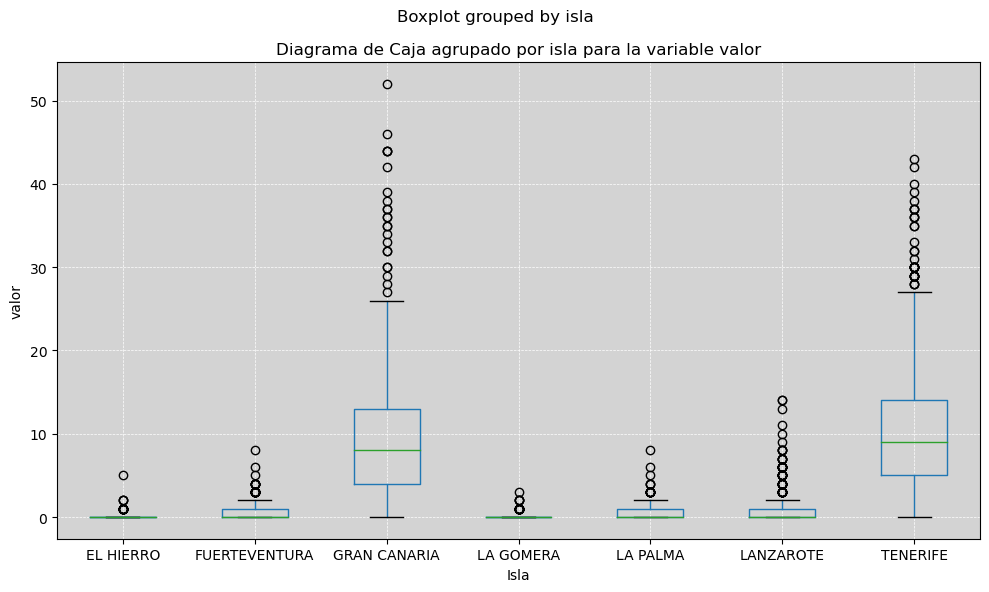

In [74]:
obtener_valores_extremos(datos_urgencias_cv, valor)

Visualizamos la evolución de los datos de todas las islas juntas.

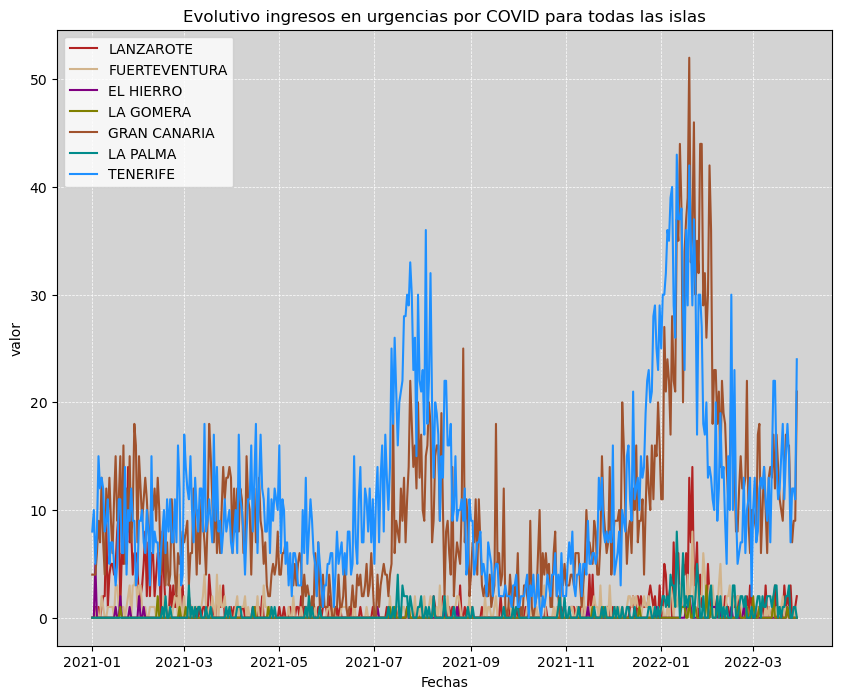

In [75]:
visualizar_evolutivo_islas(datos_urgencias_cv, valor, tit_urg_cv)

Visualizamos la evolución de los datos para cada isla individualmente.

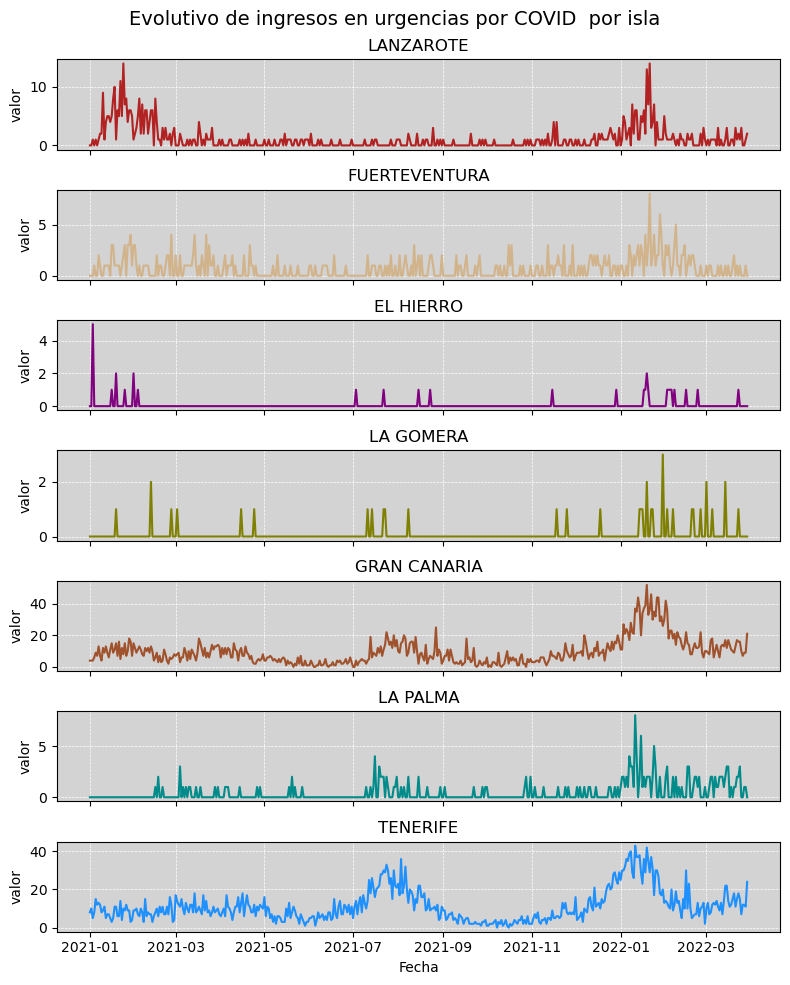

In [76]:
visualizar_evolutivo_por_isla(datos_urgencias_cv, valor, tit_urg_cv)

Visualizamos el diagrama de caja para evaluar los valores extremos.

<Figure size 1000x600 with 0 Axes>

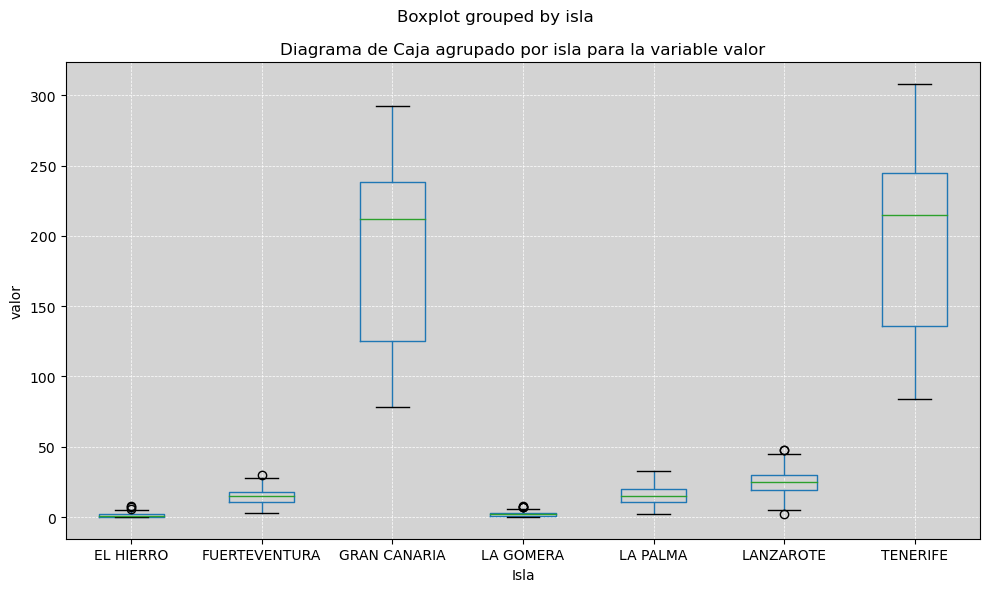

In [77]:
obtener_valores_extremos(datos_urgencias_ingr, valor)

Visualizamos la evolución de los datos de todas las islas juntas.

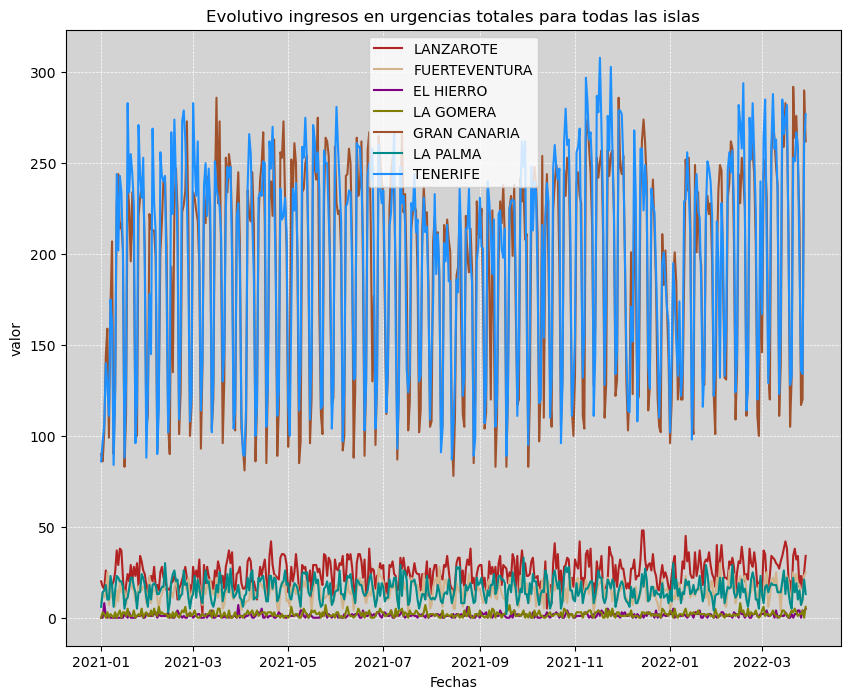

In [78]:
visualizar_evolutivo_islas(datos_urgencias_ingr, valor, tit_urg_ingr)

Visualizamos la evolución de los datos para cada isla individualmente.

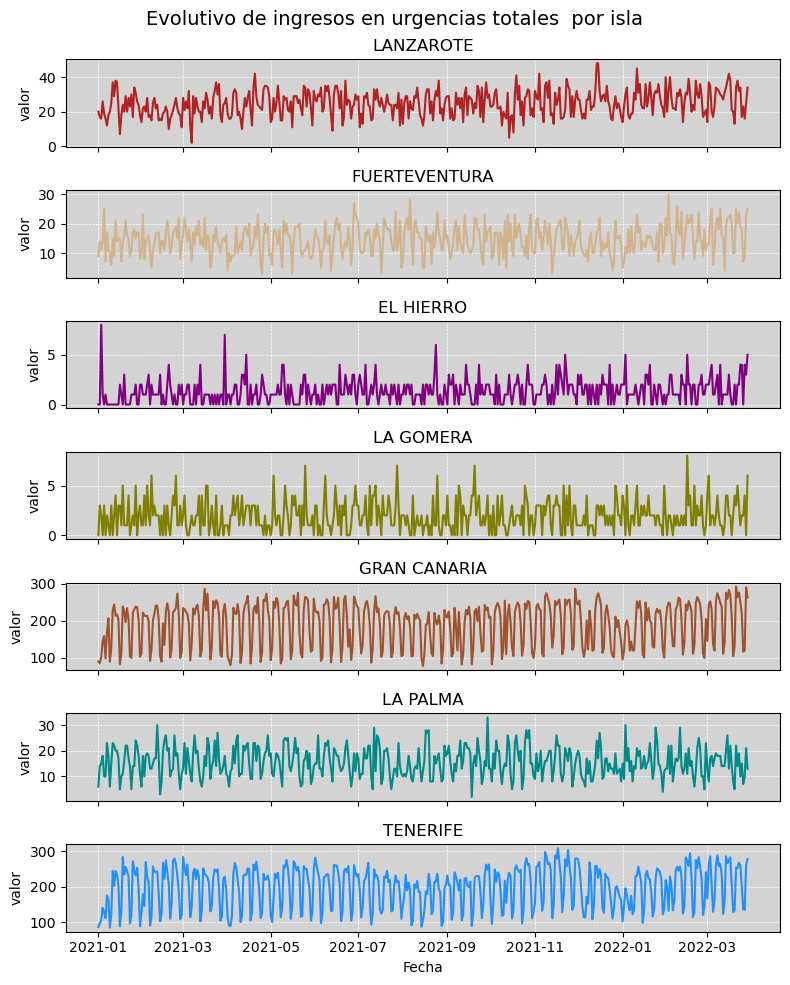

In [79]:
visualizar_evolutivo_por_isla(datos_urgencias_ingr, valor, tit_urg_ingr)

Una vez tenemos los datos agregamos al DataFrame con los datos de covid los datos de los ingresos totales y por COVID

In [80]:
# Para poder hacer la fusión debemos de pasar los datos a tipo string
df_covid_final['fecha'] = df_covid_final['fecha'].astype(str)
datos_urgencias_ingr['fecha'] = datos_urgencias_ingr['fecha'].astype(str)
datos_urgencias_cv['fecha'] = datos_urgencias_cv['fecha'].astype(str)

# Añadimos los datos de ingresos totales en el servicio de Urgencias
df_covid_final = pd.merge(df_covid_final, datos_urgencias_ingr, on=['fecha', 'isla'], how='inner')

# Renombramos la nueva columna por la de ingresos en urgencias
df_covid_final = df_covid_final.rename(columns={'valor': 'Urg_ingr'})

# Añadimos los datos de ingresos por COVID en el servicio de Urgencias
df_covid_final = pd.merge(df_covid_final, datos_urgencias_cv, on=['fecha', 'isla'], how='inner')

# Renombramos la nueva columna por la de ingresos en urgencias por COVID
df_covid_final = df_covid_final.rename(columns={'valor': 'Urg_cv'})

# Volvemos a pònerle el tipo de datos correspondientes a la variable de fechas
df_covid_final['fecha'] = pd.to_datetime(df_covid_final['fecha'])

Visualizamos el conjunto de datos resultante:

In [81]:
df_covid_final

isla      fecha  numero_casos    ia_7dias    ia_14dias  \
0         LANZAROTE 2021-01-01            14   48.134932    77.657690   
1     FUERTEVENTURA 2021-01-01             1   25.891157    49.276718   
2         EL HIERRO 2021-01-01             0   80.739212   107.652283   
3         LA GOMERA 2021-01-01             0   46.129717   156.841037   
4      GRAN CANARIA 2021-01-01            62   49.092892    83.574804   
...             ...        ...           ...         ...          ...   
3159      LANZAROTE 2022-03-28            13  134.777809   282.391600   
3160      LA GOMERA 2022-03-28            13  954.885137  1974.351877   
3161       LA PALMA 2022-03-28            63  626.662513  1386.326056   
3162      EL HIERRO 2022-03-28             4  520.319368   995.783619   
3163  FUERTEVENTURA 2022-03-28            22  140.313367   312.364280   

      pcr_total  pcr_positivos  pcr_porcentaje_positivos  \
0           212             16                  7.547170   
1            31              1                  3.225806   
2             1              0                  0.000000   
3             7              1                 14.285714   
4          1017             78                  7.669617   
...         ...            ...                       ...   
3159        266             15                  5.639098   
3160         37             16                 43.243243   
3161        298             78                 26.174497   
3162          9              5                 55.555556   
3163        169             24                 14.201183   

      pcr_porcentaje_positivos_7dias  Urg_ingr  Urg_cv  
0                           3.298153        20       0  
1                           4.934823         9       0  
2                           4.529617         0       0  
3                          12.459016         0       0  
4                           5.668176        90       4  
...                              ...       ...     ...  
3159                       17.935192        25       1  
3160                       44.134078         0       0  
3161                       27.955056        21       1  
3162                       23.465704         3       0  
3163                       15.745568        23       1  

[3164 rows x 11 columns]

# Limpieza de datos de ocupación diaria de los centro sanitarios en Canarias

Realizamos el proceso de ETL para los datos de la ocupación de camas diaria de los centros hospitalarios en Canarias.

In [82]:
#Carga de ficheros de datos
datos_ocupacion = pd.read_csv('../data/inicial/datos_capacidad_asistencial/csv_ocupacion_centros_diaria.csv', header=0)

Al igual que ocurría con los datos anteriores, este conjunto de datos viene organizado por fecha y centro por lo que debemos de cruzar los datos con los datos maestros de centros donde tenemos la isla a la que pertenece cada centro

In [83]:
# Renombramos la columna para poder fusionar el dataframe con el dataframe de centros
datos_ocupacion = datos_ocupacion.rename(columns={'codigo_centro': 'codigo'})

# Unimos el dataframe de datos de centros con el de ocupación 
datos_ocupacion = pd.merge(datos_ocupacion, datos_centros, on=['codigo'], how='left')

In [84]:
#Obtenemos las dimensiones del dataframe
shape = datos_ocupacion.shape

print("Número de atributos:", shape[1])
print("Número de filas :", shape[0])
print("Nombre de los atributos:", datos_ocupacion.columns.values)

Número de atributos: 7
Número de filas : 82377
Nombre de los atributos: ['fecha_datos' 'codigo' 'fecha' 'unidad_funcional' 'cv19' 'nocv19' 'isla']


Este dataset está compuesto por 82377 registros que corresponden con los datos de ocupación diaria existente en los centros sanitarios de las Islas Canarias y 7 variables que los caracterizan. La descripción de las variables son:

* **fecha_datos:** Fecha en la que se han extraído los datos de la base de datos de Sanidad.
* **codigo:** Código identificativo para cada centro.
* **fecha:** Fecha de los datos.
* **unidad_funcional:** Tipo de unidad funcional:
    * **CCR:** unidades críticas con respirador 
    * **CSR:** unidades críticas sin respirador 
    * **HPT:** resto de camas hospitalarias.
* **cv19:** Número de pacientes actualmente ingresados POR covid19en el tipo de unidad funcional que indique el campo unidad_funcional.
* **nocv19:** Número de pacientes no covid19 actualmente ingresados en el tipo de unidad funcional que indique el campo unidad_funcional.
* **isla:** Isla a la que pertenecen los datos.

In [85]:
comporbar_valores_perdidos(datos_ocupacion)


Valores no definidos:
fecha_datos         0
codigo              0
fecha               0
unidad_funcional    0
cv19                0
nocv19              0
isla                0
dtype: int64

Valores nulos:
fecha_datos         0
codigo              0
fecha               0
unidad_funcional    0
cv19                0
nocv19              0
isla                0
dtype: int64


Podemos observar que el conjunto de datos no posee valores perdidos. Mostramos la información de las variables para determinar que están en el tipo de datos correcto y visualizamos una muestra de los datos:

In [86]:
datos_ocupacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82377 entries, 0 to 82376
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   fecha_datos       82377 non-null  object
 1   codigo            82377 non-null  int64 
 2   fecha             82377 non-null  object
 3   unidad_funcional  82377 non-null  object
 4   cv19              82377 non-null  int64 
 5   nocv19            82377 non-null  int64 
 6   isla              82377 non-null  object
dtypes: int64(3), object(4)
memory usage: 4.4+ MB


In [87]:
datos_ocupacion.head()

fecha_datos  codigo       fecha unidad_funcional  cv19  nocv19          isla
0  30/06/2023  350367  25/09/2020              HPT     0      91  GRAN CANARIA
1  30/06/2023  380012  16/01/2023              CCR     1      37      TENERIFE
2  30/06/2023  380326  04/07/2020              CCR     0      39      TENERIFE
3  30/06/2023  380103  11/03/2022              CSR     0       0      TENERIFE
4  30/06/2023  380064  03/11/2020              CSR     0       0      TENERIFE

In [88]:
# Eliminamos los datos que no son necesarios
datos_ocupacion = datos_ocupacion[['fecha', 'isla', 'unidad_funcional', 'cv19', 'nocv19']]

# Convertimos cada variable al tipo de dato que le corresponde
datos_ocupacion['fecha'] = pd.to_datetime(datos_ocupacion['fecha'], dayfirst=True)
datos_ocupacion['isla'] = datos_ocupacion['isla'].astype(str)
datos_ocupacion['unidad_funcional'] = datos_ocupacion['unidad_funcional'].astype(str)
datos_ocupacion['cv19'] = datos_ocupacion['cv19'].astype(int)
datos_ocupacion['nocv19'] = datos_ocupacion['nocv19'].astype(int)

In [89]:
datos_ocupacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82377 entries, 0 to 82376
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fecha             82377 non-null  datetime64[ns]
 1   isla              82377 non-null  object        
 2   unidad_funcional  82377 non-null  object        
 3   cv19              82377 non-null  int32         
 4   nocv19            82377 non-null  int32         
dtypes: datetime64[ns](1), int32(2), object(2)
memory usage: 2.5+ MB


En este conjunto de datos para cada fecha y para cada centro tenemos tres registros, uno para la ocupación de unidades críticas sin respirador, otro para la ocupación de las unidades críticas con respirador y otro para el resto de camas, debemos dividir el conjunto de datos en tres subconjuntos para poder manipular los datos.

Dado que los datos de los ingresos en el serivicio de urgencias posee más datos que el periodo de fechas establecido acotamos los datos de forma que sólo obtengamos los datos comprendidos entre el periodo del 01/01/2021 al 29/03/2022.

In [90]:
# Obtenemos el rango de fechas indicado
rango_fechas_ocupacion = (datos_ocupacion['fecha'] >= fecha_inicio) & (datos_ocupacion['fecha'] <= fecha_fin)
datos_ocupacion = datos_ocupacion[rango_fechas_ocupacion]

# Ordenamos por fecha
datos_ocupacion = datos_ocupacion.sort_values(by='fecha')

# Agrupamos los valores por fecha, isla y unidad funcional
datos_ocupacion = datos_ocupacion.groupby(['fecha','isla', 'unidad_funcional'], as_index=False).sum()

In [91]:
# listado de unidades funcionales disponibles
unidades = datos_ocupacion['unidad_funcional'].unique()
print(unidades)

['CCR' 'CSR' 'HPT']


In [92]:
# Datos para el resto de camas
datos_ocupacion_hpt = datos_ocupacion[datos_ocupacion['unidad_funcional'] == 'HPT']
datos_ocupacion_hpt = datos_ocupacion_hpt[['isla', 'fecha', 'cv19', 'nocv19']]

# Datos para la ocupación de camas con respirador
datos_ocupacion_ccr = datos_ocupacion[datos_ocupacion['unidad_funcional'] == 'CCR']
datos_ocupacion_ccr = datos_ocupacion_ccr[['isla', 'fecha', 'cv19', 'nocv19']]

# Datos para la ocupación de camas sin respirador
datos_ocupacion_csr = datos_ocupacion[datos_ocupacion['unidad_funcional'] == 'CSR']
datos_ocupacion_csr = datos_ocupacion_csr[['isla', 'fecha', 'cv19', 'nocv19']]

Comprobamos la existencia de alguna fecha sin datos para cada isla

In [93]:
comprobar_fechas(datos_ocupacion_hpt, valores_islas)

Fechas faltantes para LANZAROTE: []
Fechas faltantes para FUERTEVENTURA: []
Fechas faltantes para EL HIERRO: [Timestamp('2021-11-19 00:00:00')]
Fechas faltantes para LA GOMERA: []
Fechas faltantes para GRAN CANARIA: []
Fechas faltantes para LA PALMA: []
Fechas faltantes para TENERIFE: []


In [94]:
comprobar_fechas(datos_ocupacion_ccr, valores_islas)

Fechas faltantes para LANZAROTE: []
Fechas faltantes para FUERTEVENTURA: []
Fechas faltantes para EL HIERRO: [Timestamp('2021-11-19 00:00:00')]
Fechas faltantes para LA GOMERA: []
Fechas faltantes para GRAN CANARIA: []
Fechas faltantes para LA PALMA: []
Fechas faltantes para TENERIFE: []


In [95]:
comprobar_fechas(datos_ocupacion_csr, valores_islas)

Fechas faltantes para LANZAROTE: []
Fechas faltantes para FUERTEVENTURA: []
Fechas faltantes para EL HIERRO: [Timestamp('2021-11-19 00:00:00')]
Fechas faltantes para LA GOMERA: []
Fechas faltantes para GRAN CANARIA: []
Fechas faltantes para LA PALMA: []
Fechas faltantes para TENERIFE: []


Nuevamente podemos observar que la isla de El Hierro no posee datos para la fecha del 19/11/2021, por lo que siguiendo la estrategia anterior aplicaremos el valor medio de la fecha anterior y posterior a la fecha faltante

In [96]:
# Fecha para la que faltan los datos
fecha_faltante = pd.to_datetime('2021-11-19')

# Valor medio de pacientes covid para el resto de camas
valor_medio_hpt_cv19 = obtener_valor_media_ant_sig(datos_ocupacion_hpt, fecha_faltante, 'cv19')

# Valor medio de pacientes no covid par ael resto de camas
valor_medio_hpt_nocv19 = obtener_valor_media_ant_sig(datos_ocupacion_hpt, fecha_faltante, 'nocv19')

# Valor medio de pacientes covid para las camas con respirador
valor_medio_ccr_cv19 = obtener_valor_media_ant_sig(datos_ocupacion_ccr, fecha_faltante, 'cv19')
# Valor medio de pacientes no covid para las camas con respirador
valor_medio_ccr_nocv19 = obtener_valor_media_ant_sig(datos_ocupacion_ccr, fecha_faltante, 'nocv19')

# Valor medio de pacientes covid para las camas sin respirador
valor_medio_csr_cv19 = obtener_valor_media_ant_sig(datos_ocupacion_csr, fecha_faltante, 'cv19')

# Valor medio de pacientes no covid para las camas sin respirdor
valor_medio_csr_nocv19 = obtener_valor_media_ant_sig(datos_ocupacion_csr, fecha_faltante, 'nocv19')


In [97]:
# Añadimos los datos del resto de camas para la fecha faltante
fila_faltante_hpt = pd.DataFrame({'fecha': [fecha_faltante], 'isla': 'EL HIERRO', 'cv19': [valor_medio_hpt_cv19], 'nocv19': [valor_medio_hpt_nocv19]})
datos_ocupacion_hpt = pd.concat([datos_ocupacion_hpt, fila_faltante_hpt], ignore_index=True)

# Añadimos los datos de las camas con respirador para la fecha faltante
fila_faltante_ccr = pd.DataFrame({'fecha': [fecha_faltante], 'isla': 'EL HIERRO', 'cv19': [valor_medio_ccr_cv19], 'nocv19': [valor_medio_ccr_nocv19]})
datos_ocupacion_ccr = pd.concat([datos_ocupacion_ccr, fila_faltante_ccr], ignore_index=True)

# Añadimos los datos de las camas sin respirador para la fecha faltante
fila_faltante_csr = pd.DataFrame({'fecha': [fecha_faltante], 'isla': 'EL HIERRO', 'cv19': [valor_medio_csr_cv19], 'nocv19': [valor_medio_csr_nocv19]})
datos_ocupacion_csr = pd.concat([datos_ocupacion_csr, fila_faltante_csr], ignore_index=True)

In [98]:
datos_ocupacion_hpt = datos_ocupacion_hpt.sort_values(by='fecha')
datos_ocupacion_ccr = datos_ocupacion_ccr.sort_values(by='fecha')
datos_ocupacion_csr = datos_ocupacion_csr.sort_values(by='fecha')

In [99]:
# Constantes con los nombres de las columnas a visualizar el diagrama de caja y el evolutivo

cv19 = 'cv19'
nocv19 = 'nocv19'

tit_hpt_cv = 'número de pacientes COVID en el resto de camas'
tit_hpt_nocv = 'número de pacientes no COVID en el resto de camas'
tit_ccr_cv = 'número de pacientes COVID en unidades críticas con respirador'
tit_ccr_nocv = 'número de pacientes no COVID en unidades críticas con respirador'
tit_csr_cv = 'número de pacientes COVID en unidades críticas sin respirador'
tit_csr_nocv = 'número de pacientes no COVID en unidades críticas sin respirador'

Visualizamos el diagrama de caja para evaluar los valores extremos.

<Figure size 1000x600 with 0 Axes>

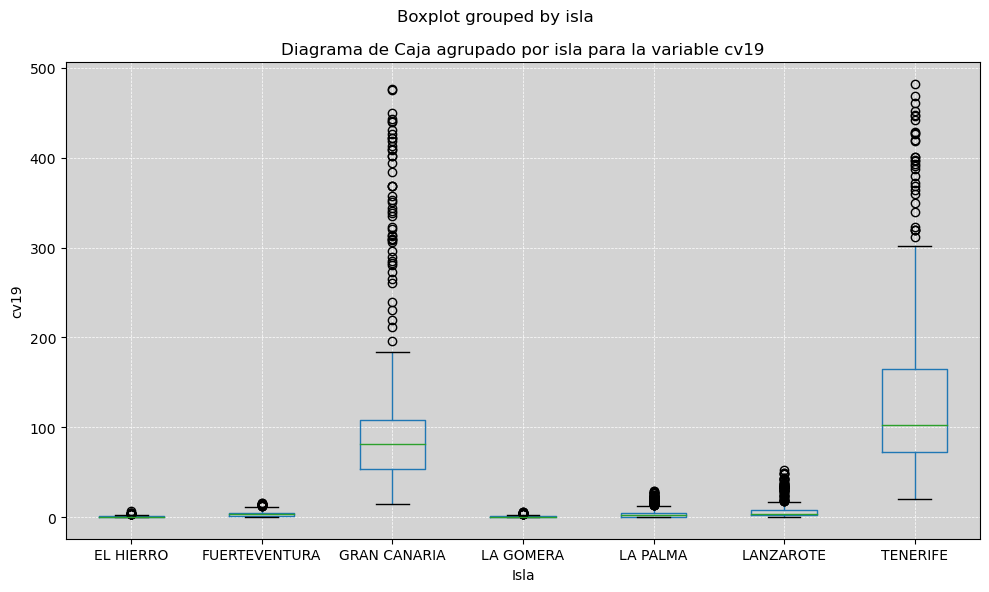

In [100]:
obtener_valores_extremos(datos_ocupacion_hpt, cv19)

Visualizamos la evolución de los datos de todas las islas juntas.

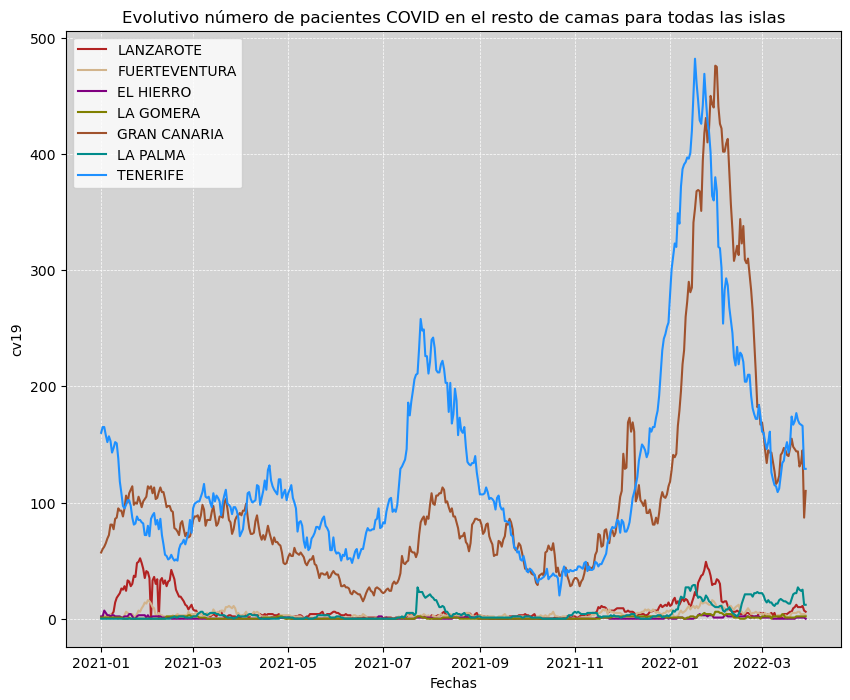

In [101]:
visualizar_evolutivo_islas(datos_ocupacion_hpt, cv19, tit_hpt_cv)

Visualizamos la evolución de los datos para cada isla individualmente.

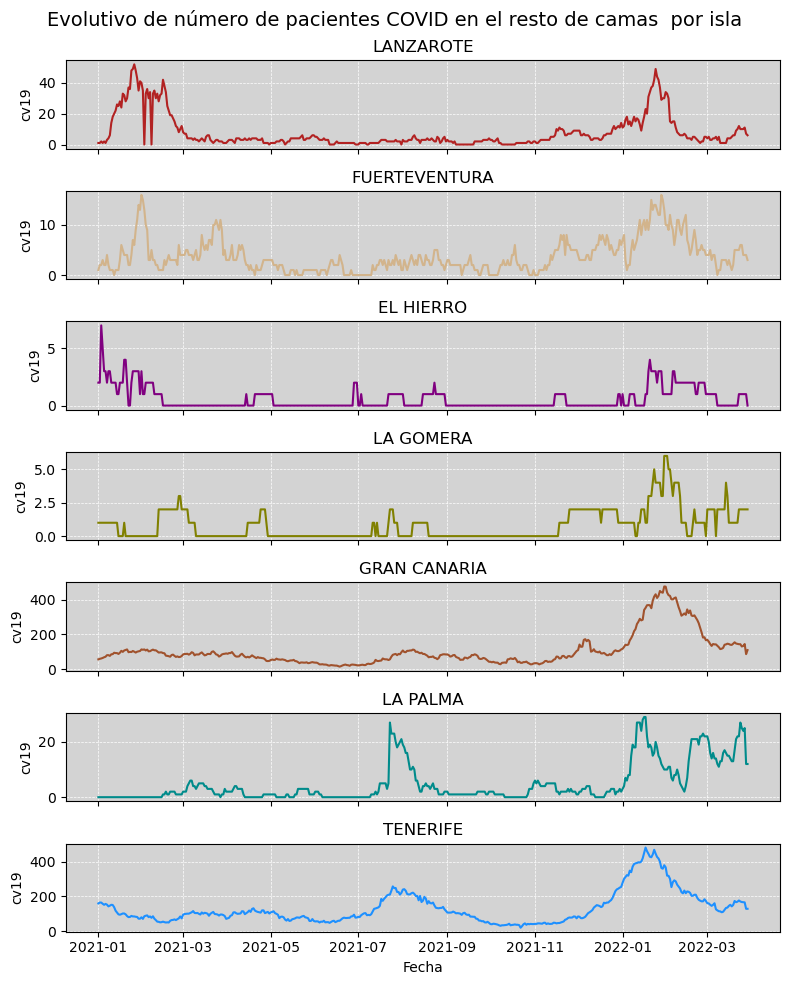

In [102]:
visualizar_evolutivo_por_isla(datos_ocupacion_hpt, cv19, tit_hpt_cv)

Visualizamos el diagrama de caja para evaluar los valores extremos.

<Figure size 1000x600 with 0 Axes>

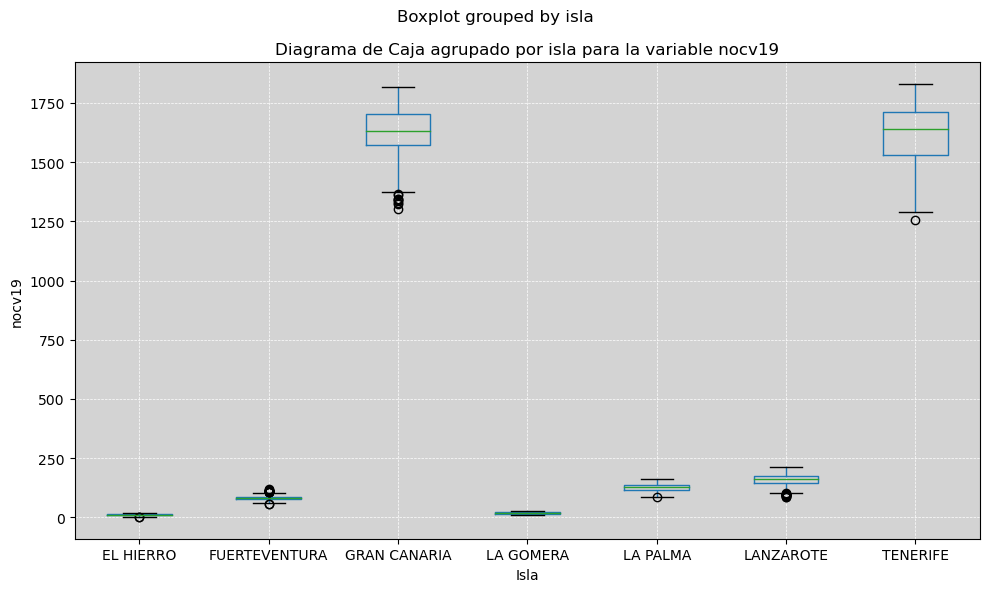

In [103]:
obtener_valores_extremos(datos_ocupacion_hpt, nocv19)

Visualizamos la evolución de los datos de todas las islas juntas.

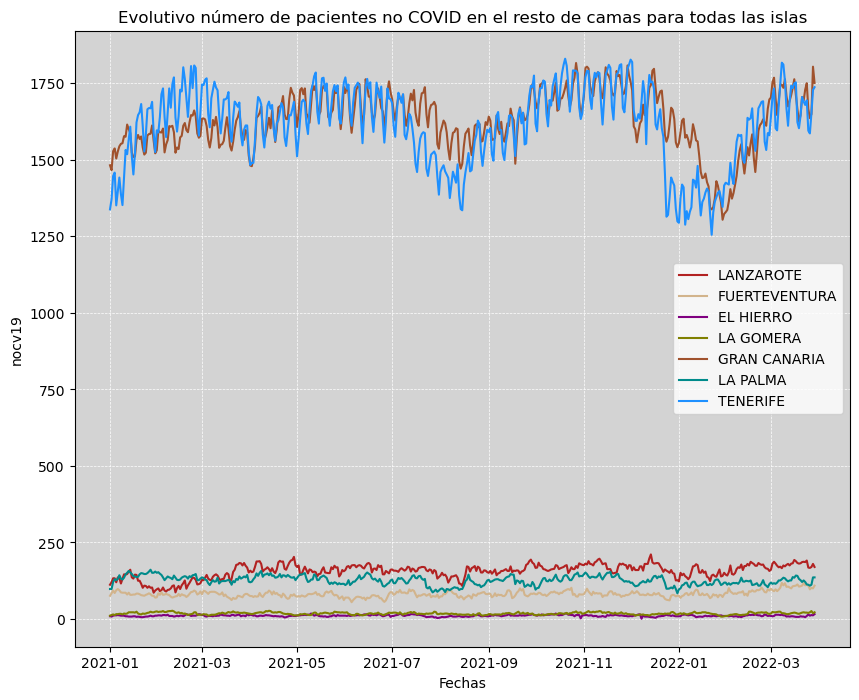

In [104]:
visualizar_evolutivo_islas(datos_ocupacion_hpt, nocv19, tit_hpt_nocv)

Visualizamos la evolución de los datos para cada isla individualmente.

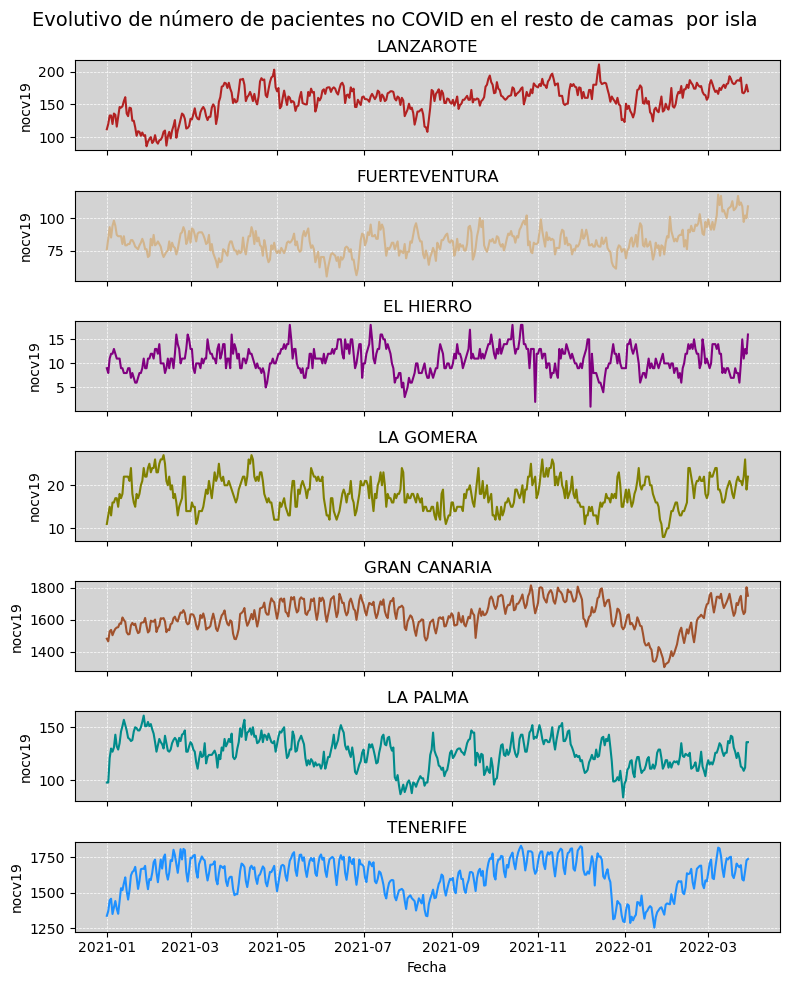

In [105]:
visualizar_evolutivo_por_isla(datos_ocupacion_hpt, nocv19, tit_hpt_nocv)

Visualizamos el diagrama de caja para evaluar los valores extremos.

<Figure size 1000x600 with 0 Axes>

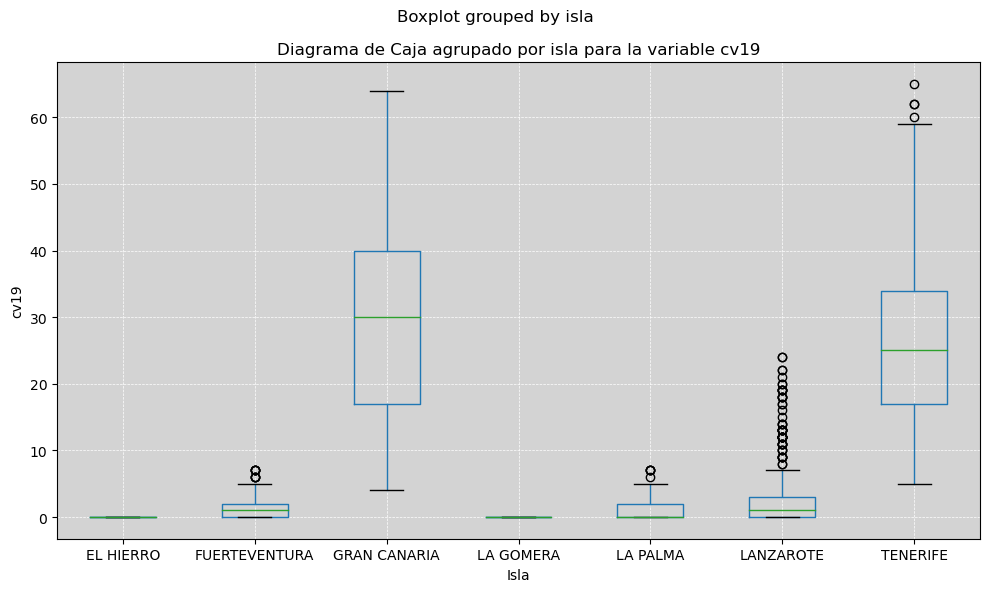

In [106]:
obtener_valores_extremos(datos_ocupacion_ccr, cv19)

Visualizamos la evolución de los datos de todas las islas juntas.

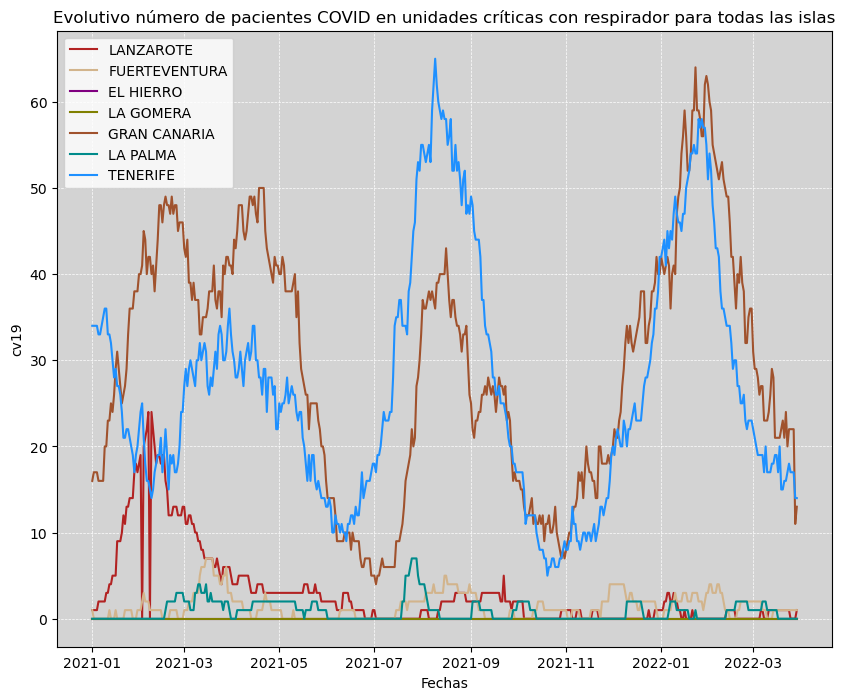

In [107]:
visualizar_evolutivo_islas(datos_ocupacion_ccr, cv19, tit_ccr_cv)

Visualizamos la evolución de los datos para cada isla individualmente.

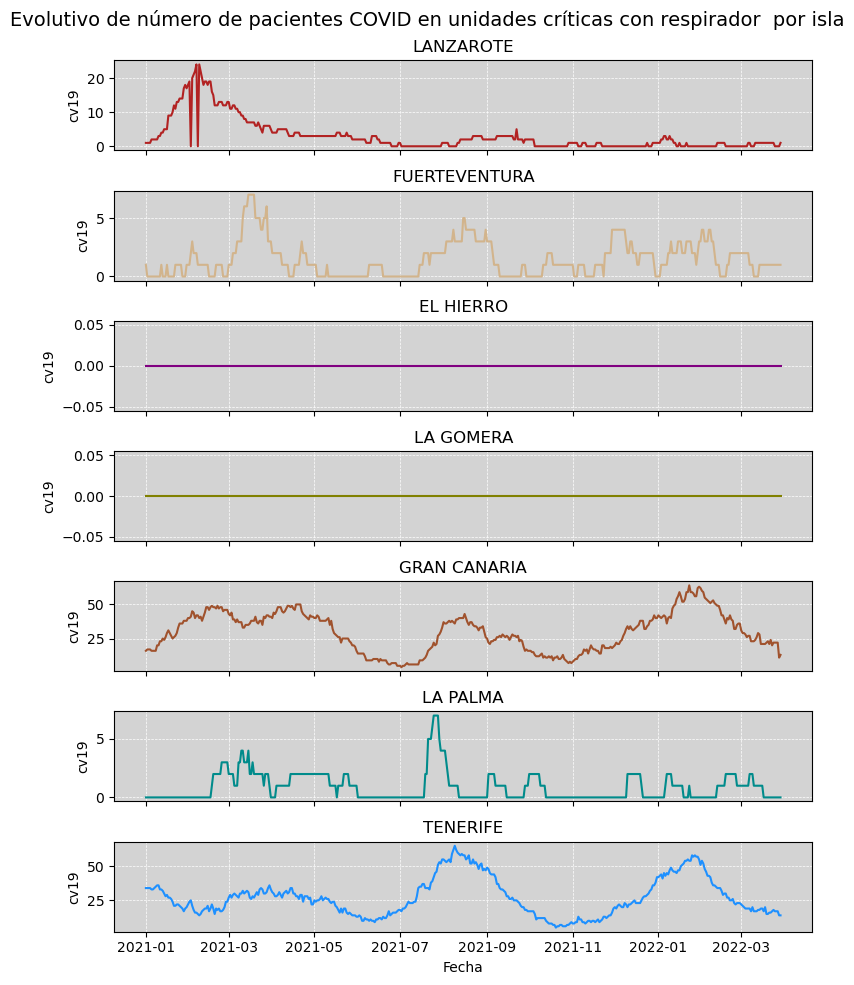

In [108]:
visualizar_evolutivo_por_isla(datos_ocupacion_ccr, cv19, tit_ccr_cv)

Visualizamos el diagrama de caja para evaluar los valores extremos.

<Figure size 1000x600 with 0 Axes>

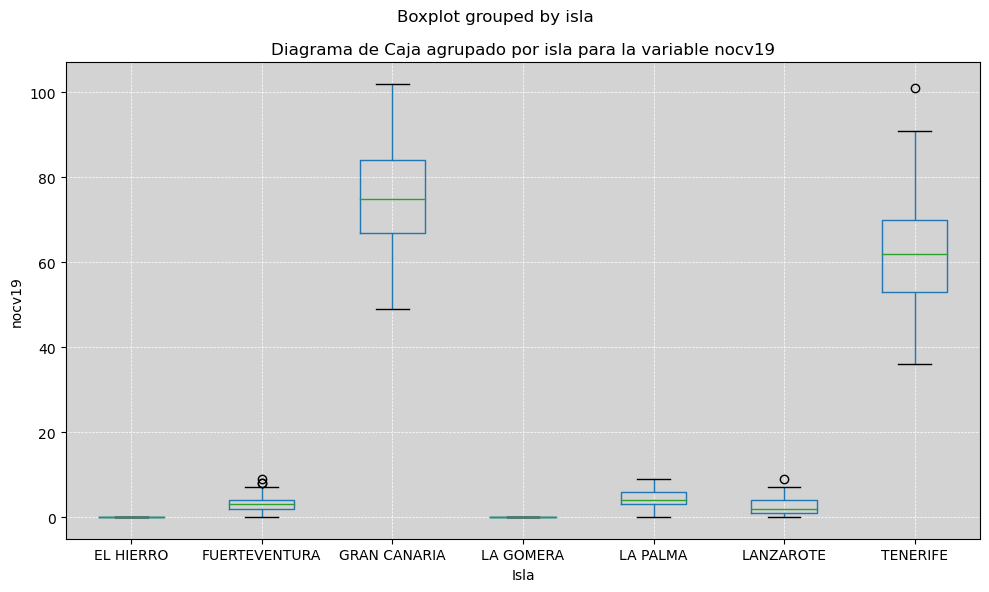

In [109]:
obtener_valores_extremos(datos_ocupacion_ccr, nocv19)

Visualizamos la evolución de los datos de todas las islas juntas.

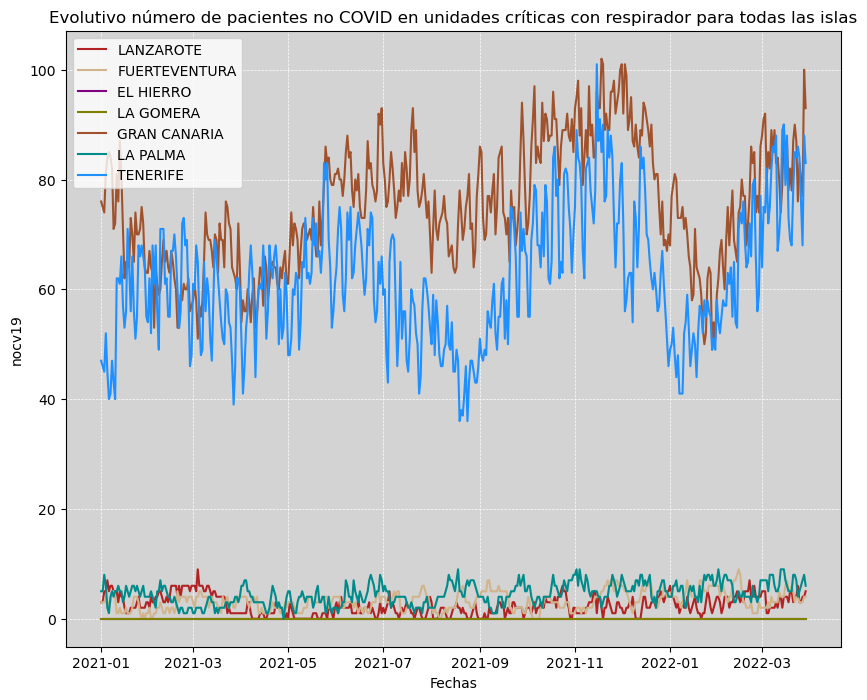

In [110]:
visualizar_evolutivo_islas(datos_ocupacion_ccr, nocv19, tit_ccr_nocv)

Visualizamos la evolución de los datos para cada isla individualmente.

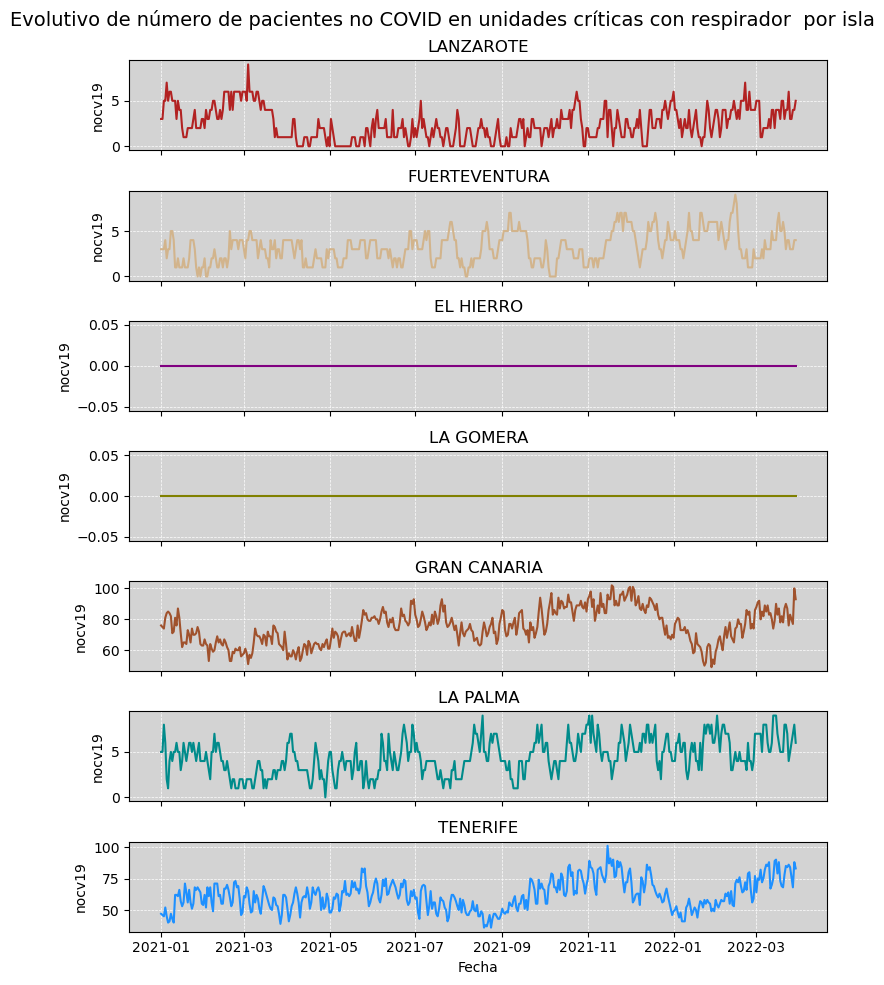

In [111]:
visualizar_evolutivo_por_isla(datos_ocupacion_ccr, nocv19, tit_ccr_nocv)

Visualizamos el diagrama de caja para evaluar los valores extremos.

<Figure size 1000x600 with 0 Axes>

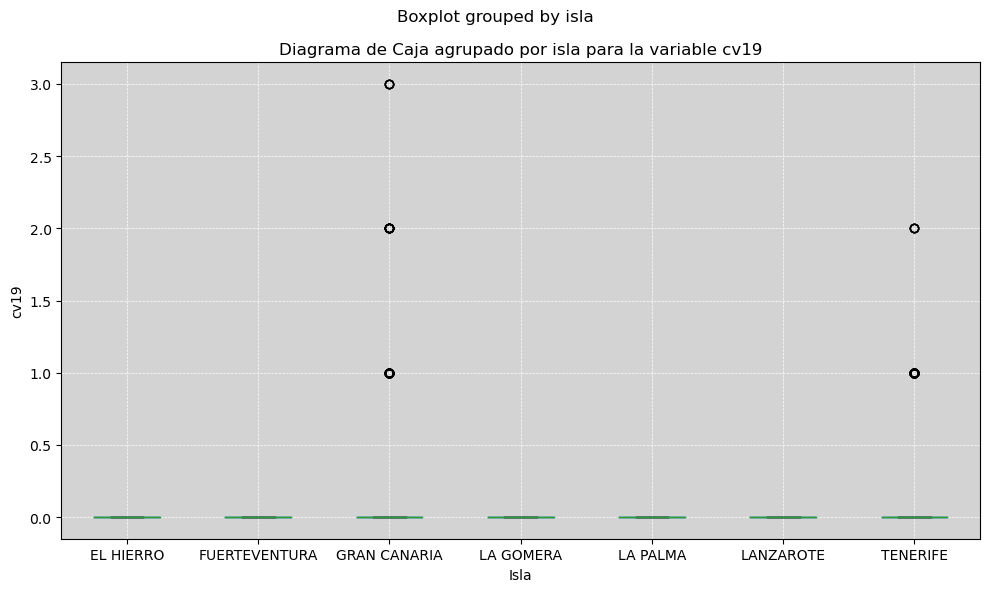

In [112]:
obtener_valores_extremos(datos_ocupacion_csr, cv19)

Visualizamos la evolución de los datos de todas las islas juntas.

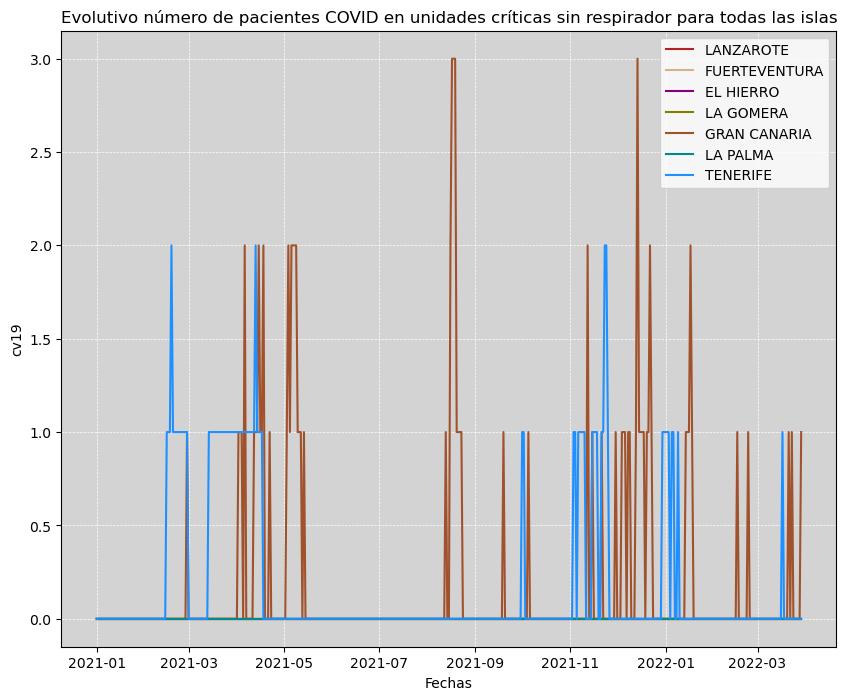

In [113]:
visualizar_evolutivo_islas(datos_ocupacion_csr, cv19, tit_csr_cv)

Visualizamos la evolución de los datos para cada isla individualmente.

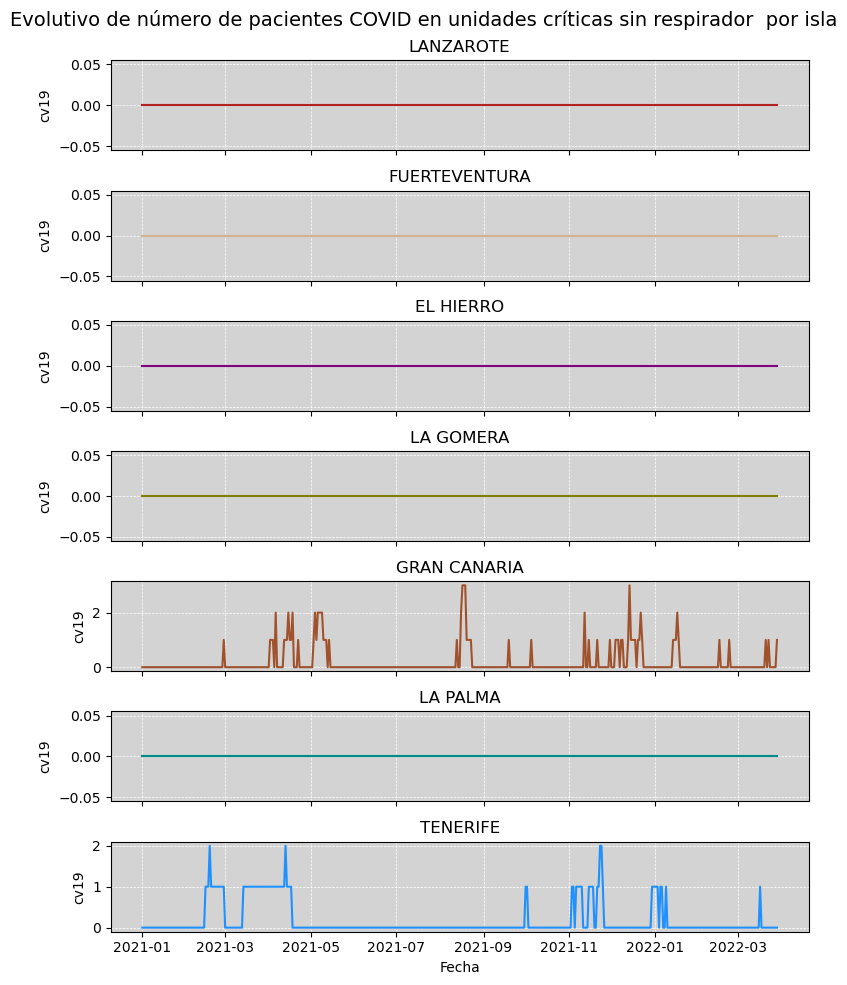

In [114]:
visualizar_evolutivo_por_isla(datos_ocupacion_csr, cv19, tit_csr_cv)

Visualizamos el diagrama de caja para evaluar los valores extremos.

<Figure size 1000x600 with 0 Axes>

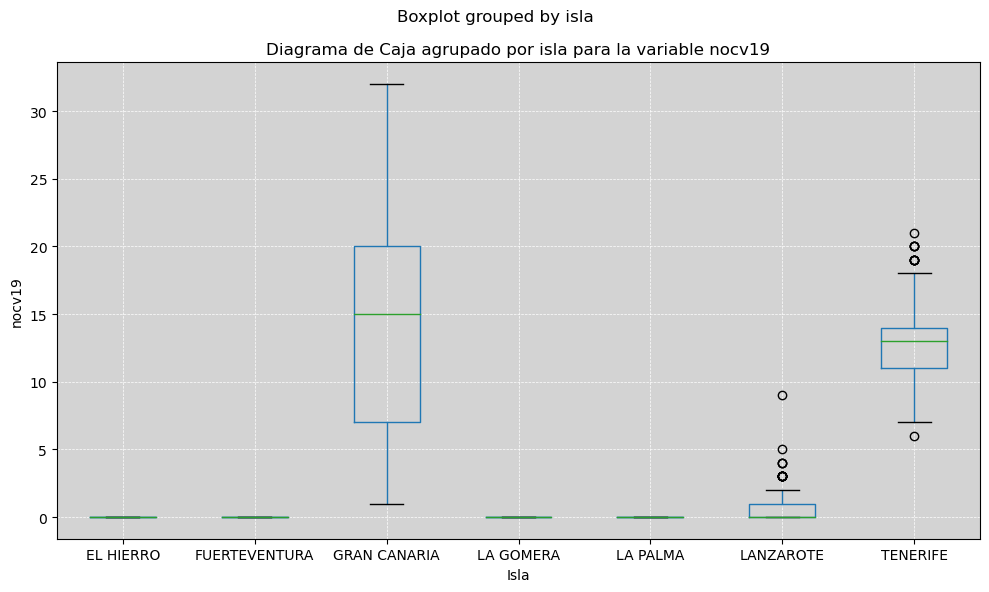

In [115]:
obtener_valores_extremos(datos_ocupacion_csr, nocv19)

Visualizamos la evolución de los datos de todas las islas juntas.

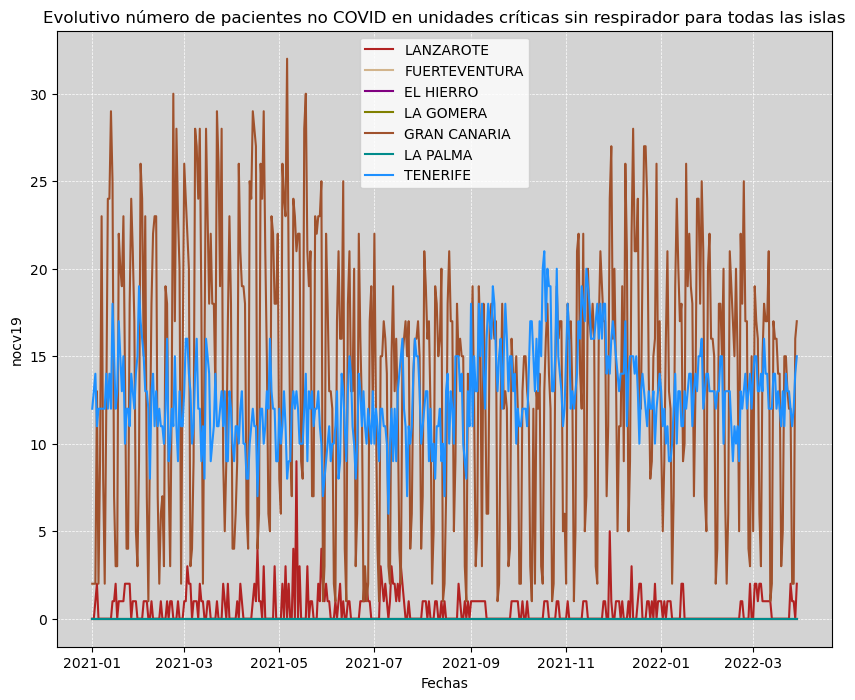

In [116]:
visualizar_evolutivo_islas(datos_ocupacion_csr, nocv19, tit_csr_nocv)

Visualizamos la evolución de los datos para cada isla individualmente.

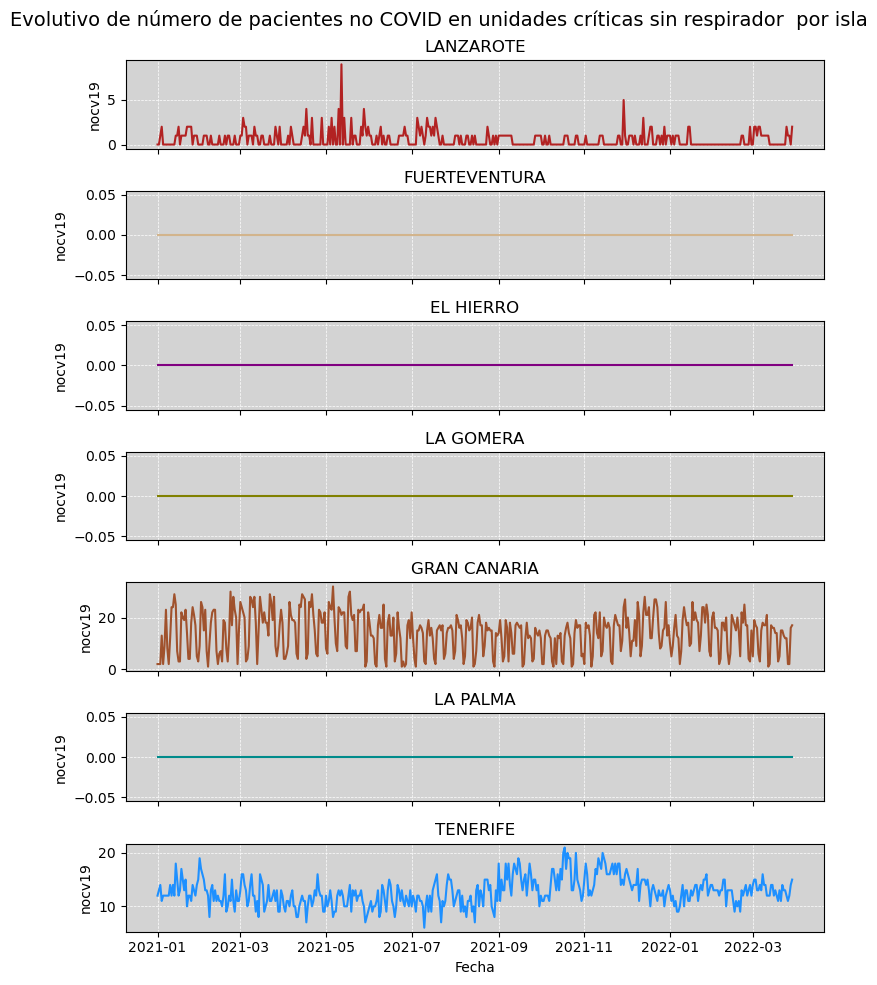

In [117]:
visualizar_evolutivo_por_isla(datos_ocupacion_csr, nocv19, tit_csr_nocv)

In [118]:
# Para poder hacer la fusión debemos de pasar los datos a tipo string
df_covid_final['fecha'] = df_covid_final['fecha'].astype(str)
datos_ocupacion_hpt['fecha'] = datos_ocupacion_hpt['fecha'].astype(str)
datos_ocupacion_ccr['fecha'] = datos_ocupacion_ccr['fecha'].astype(str)
datos_ocupacion_csr['fecha'] = datos_ocupacion_csr['fecha'].astype(str)

# Añadimos los datos del resto de camas al dataset final
df_covid_final = pd.merge(df_covid_final, datos_ocupacion_hpt, on=['fecha', 'isla'], how='inner')

# Renombramos las columnas para asignarles el valor de unidad correspondiente
df_covid_final = df_covid_final.rename(columns={'cv19': 'HPT_cv19'})
df_covid_final = df_covid_final.rename(columns={'nocv19': 'HPT_nocv19'})

# Añadimos los datos de las camas con respirador al dataset final
df_covid_final = pd.merge(df_covid_final, datos_ocupacion_ccr, on=['fecha', 'isla'], how='inner')

# Renombramos las columnas para asignarles el valor de unidad correspondiente
df_covid_final = df_covid_final.rename(columns={'cv19': 'CCR_cv19'})
df_covid_final = df_covid_final.rename(columns={'nocv19': 'CCR_nocv19'})

# Añadimos los datos de las camas sin respirador al dataset final
df_covid_final = pd.merge(df_covid_final, datos_ocupacion_csr, on=['fecha', 'isla'], how='inner')

# Renombramos las columnas para asignarles el valor de unidad correspondiente
df_covid_final = df_covid_final.rename(columns={'cv19': 'CSR_cv19'})
df_covid_final = df_covid_final.rename(columns={'nocv19': 'CSR_nocv19'})

# Devolvemos el valor correcto a la variable de fecha
df_covid_final['fecha'] = pd.to_datetime(df_covid_final['fecha'])

Visualizamos el conjunto de datos resultante:

In [119]:
df_covid_final

isla      fecha  numero_casos    ia_7dias    ia_14dias  \
0         LANZAROTE 2021-01-01            14   48.134932    77.657690   
1     FUERTEVENTURA 2021-01-01             1   25.891157    49.276718   
2         EL HIERRO 2021-01-01             0   80.739212   107.652283   
3         LA GOMERA 2021-01-01             0   46.129717   156.841037   
4      GRAN CANARIA 2021-01-01            62   49.092892    83.574804   
...             ...        ...           ...         ...          ...   
3159      LANZAROTE 2022-03-28            13  134.777809   282.391600   
3160      LA GOMERA 2022-03-28            13  954.885137  1974.351877   
3161       LA PALMA 2022-03-28            63  626.662513  1386.326056   
3162      EL HIERRO 2022-03-28             4  520.319368   995.783619   
3163  FUERTEVENTURA 2022-03-28            22  140.313367   312.364280   

      pcr_total  pcr_positivos  pcr_porcentaje_positivos  \
0           212             16                  7.547170   
1            31              1                  3.225806   
2             1              0                  0.000000   
3             7              1                 14.285714   
4          1017             78                  7.669617   
...         ...            ...                       ...   
3159        266             15                  5.639098   
3160         37             16                 43.243243   
3161        298             78                 26.174497   
3162          9              5                 55.555556   
3163        169             24                 14.201183   

      pcr_porcentaje_positivos_7dias  Urg_ingr  Urg_cv  HPT_cv19  HPT_nocv19  \
0                           3.298153        20       0         1         112   
1                           4.934823         9       0         1          76   
2                           4.529617         0       0         2           9   
3                          12.459016         0       0         1          11   
4                           5.668176        90       4        57        1482   
...                              ...       ...     ...       ...         ...   
3159                       17.935192        25       1         7         180   
3160                       44.134078         0       0         2          19   
3161                       27.955056        21       1        12         136   
3162                       23.465704         3       0         1          12   
3163                       15.745568        23       1         4         100   

      CCR_cv19  CCR_nocv19  CSR_cv19  CSR_nocv19  
0            1           3         0           0  
1            1           3         0           0  
2            0           0         0           0  
3            0           0         0           0  
4           16          76         0           2  
...        ...         ...       ...         ...  
3159         0           4         0           0  
3160         0           0         0           0  
3161         0           8         0           0  
3162         0           0         0           0  
3163         1           4         0           0  

[3164 rows x 17 columns]

In [120]:
ruta_fichero = "../data/Intermedio/" 
nombre_fichero = "datos_covid.csv"

# Escribimos el dataset final en un fichero csv
df_covid_final.to_csv(ruta_fichero + nombre_fichero, index=False)